### In this notebook, I tried to reproduce the results of the following papers

Kubo et al., 2009 (Seismological and experimental constraints on metastable phase transformations
and rheology of the Mariana slab)

Note:
- some of the equations still don't show correctly. Also they seem to mess up the title when they are presented in the "OUTLINE".

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt

root_path = os.path.join(Path().resolve().parent.parent)
package_path = os.path.join(root_path, "hamageolib")

if str(package_path) not in sys.path:
    sys.path.insert(0, str(package_path))


from utils.exception_handler import my_assert
import utils.plot_helper as plot_helper

base_dir = Path().resolve()

results_dir = os.path.join(root_path, "dtemp")
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

### Utility functions

In [2]:
from vtk.util.numpy_support import vtk_to_numpy
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree

def idw_interpolation(points, values, query_points, k=5, power=1):
    """
    Perform inverse distance weighting (IDW) interpolation.

    Args:
        points (np.ndarray): Coordinates of known data points (N x D).
        values (np.ndarray): Values at the known data points (N,).
        query_points (np.ndarray): Coordinates of query points (M x D).
        k (int): Number of nearest neighbors to consider for interpolation.
        power (int): Power parameter for the inverse distance weighting.

    Returns:
        np.ndarray: Interpolated values at the query points (M,).
    """
    # Ensure values are a NumPy array
    values = np.asarray(values)
    
    # Build a KDTree for fast nearest-neighbor lookup
    tree = cKDTree(points)

    # Find the k nearest neighbors for each query point
    distances, indices = tree.query(query_points, k=k)

    # Handle zero distances (avoid division by zero)
    distances = np.maximum(distances, 1e-12)

    # Compute weights as the inverse distance raised to the power
    weights = 1 / distances**power

    # Normalize weights
    weights /= weights.sum(axis=1, keepdims=True)

    # Interpolate the values
    print("indices: ", indices) # debug
    interpolated_values = np.sum(weights * values[indices], axis=1)

    return interpolated_values


def extract_contour_coordinates(xv, yv, t_sub_grid, levels, spacing=None):
    """
    Extracts the x and y coordinates of contours from a meshed grid and field data.

    Args:
        xv (numpy.ndarray): 2D array of x-coordinates.
        yv (numpy.ndarray): 2D array of y-coordinates.
        t_sub_grid (numpy.ndarray): 2D array of field data on the grid.
        levels (list or array): Contour levels (values) to extract.
        spacing (float, optional): Desired spacing between contour points. Defaults to None.

    Returns:
        dict: A dictionary with levels as keys and (x, y) coordinate arrays as values.
    """
    # Create the contour object
    contours = plt.contour(xv, yv, t_sub_grid, levels=levels)

    my_assert(len(contours.collections) == len(levels), ValueError,\
              "Values of collections (%d) do not equal the provided levels(%d)"\
                  % (len(contours.collections), len(levels)))

    contour_coordinates = {}
    for i, level in enumerate(levels):
        x_coords = []
        y_coords = []

        # Extract paths for the given level
        for path in contours.collections[i].get_paths():
            vertices = path.vertices  # Extract contour points
            xs, ys = vertices[:, 0], vertices[:, 1]

            if spacing is not None and len(xs) > 1:
                # Calculate cumulative distances along the contour
                distances = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)
                cumulative_distances = np.concatenate([[0], np.cumsum(distances)])

                # Create interpolation functions for x and y
                interp_x = interp1d(cumulative_distances, xs, kind='cubic', bounds_error=False, fill_value="extrapolate")
                interp_y = interp1d(cumulative_distances, ys, kind='cubic', bounds_error=False, fill_value="extrapolate")

                # Generate new cumulative distances with the desired spacing
                cumulative_distances_with_spacing = np.arange(0, cumulative_distances[-1], spacing)

                # Interpolate x and y for evenly spaced points
                xs = interp_x(cumulative_distances_with_spacing)
                ys = interp_y(cumulative_distances_with_spacing)

            x_coords.extend(xs)
            y_coords.extend(ys)

        contour_coordinates[level] = (np.array(x_coords), np.array(y_coords))
    
    plt.close()  # Close the plot to avoid displaying it
    return contour_coordinates


def offset_curve(X, Y, d):
    # Compute tangents as finite differences
    dX = np.gradient(X)
    dY = np.gradient(Y)
    
    # Compute normals by rotating tangents 90 degrees
    normals = np.array([dY, -dX]).T  # Rotate tangent vectors
    norm_length = np.linalg.norm(normals, axis=1, keepdims=True)
    normals = normals / norm_length  # Normalize to unit vectors
    
    # Offset points by the normal vectors scaled by the distance d
    X_offset = X + d * normals[:, 0]
    Y_offset = Y + d * normals[:, 1]
    
    return X_offset, Y_offset

def process_segments(slab_segments, n_spacing=10):
    """
    Processes segments to generate a continuous curve based on lengths and dip angles.

    Args:
        slab_segments (list): List of segment dictionaries with 'length' and 'angle' keys.
        n_spacing (int): Number of points per segment for interpolation.

    Returns:
        tuple: A tuple containing:
            - lengths (numpy.ndarray): Accumulated lengths at each point.
            - depths (numpy.ndarray): Accumulated depths at each point.
            - dip_angles (numpy.ndarray): Corresponding dip angles at each point.
            - Xs (numpy.ndarray): X coordinates of each point.
    """
    # Calculate the total number of points in advance
    total_points = sum(n_spacing for _ in slab_segments)

    # Preallocate arrays
    lengths = np.zeros(total_points)
    depths = np.zeros(total_points)
    dip_angles = np.zeros(total_points)
    Xs = np.zeros(total_points)

    accumulated_length = 0
    accumulated_depth = 0
    accumulated_x = 0
    current_index = 0

    for segment in slab_segments:
        # Extract length and angle pair
        length = segment['length']
        angle_pair = segment['angle']

        # Generate n_spacing points for angles and step lengths
        segment_angles = np.linspace(angle_pair[0], angle_pair[1], n_spacing)
        step_length = length / (n_spacing - 1)  # Incremental length per step

        # Calculate incremental depths and X increments for each step
        segment_depth_increments = step_length * (
            np.sin(np.radians(segment_angles[:-1])) + np.sin(np.radians(segment_angles[1:]))
        ) / 2.0  # Midpoint rule for depth integration

        segment_x_increments = step_length * (
            np.cos(np.radians(segment_angles[:-1])) + np.cos(np.radians(segment_angles[1:]))
        ) / 2.0  # Midpoint rule for X integration

        # Accumulated lengths and depths
        segment_accumulated_lengths = accumulated_length + np.arange(n_spacing) * step_length
        segment_depths = accumulated_depth + np.concatenate([np.array([0]), np.cumsum(segment_depth_increments)])
        segment_xs = accumulated_x + np.concatenate([np.array([0]), np.cumsum(segment_x_increments)])

        # Write to preallocated arrays
        lengths[current_index:current_index + n_spacing] = segment_accumulated_lengths
        depths[current_index:current_index + n_spacing] = segment_depths
        dip_angles[current_index:current_index + n_spacing] = segment_angles
        Xs[current_index:current_index + n_spacing] = segment_xs

        # Update accumulations for the next segment
        accumulated_length = segment_accumulated_lengths[-1]
        accumulated_depth = segment_depths[-1]
        accumulated_x = segment_xs[-1]
        current_index += n_spacing

    return lengths, depths, dip_angles, Xs


def distances_to_curve(Xs, Ys, x, y):
    """
    Computes the signed distance from each point in (x, y) to a curve defined by (Xs, Ys).

    Positive distance: below the curve (smaller y).
    Negative distance: above the curve (larger y).

    Args:
        Xs (numpy.ndarray): X-coordinates of the curve points (1D array).
        Ys (numpy.ndarray): Y-coordinates of the curve points (1D array).
        x (numpy.ndarray): X-coordinates of the points (1D array).
        y (numpy.ndarray): Y-coordinates of the points (1D array).

    Returns:
        numpy.ndarray: The signed distance from each point in (x, y) to the curve (1D array).
    """
    # Ensure x and y are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)

    # Reshape (x, y) to allow broadcasting against (Xs, Ys)
    x = x[:, np.newaxis]  # Shape (n_points, 1)
    y = y[:, np.newaxis]  # Shape (n_points, 1)

    # Compute squared distances for all combinations
    distances_squared = (Xs - x) ** 2 + (Ys - y) ** 2  # Shape (n_points, len(Xs))

    # Find the index of the closest point on the curve for each query point
    min_indices = np.argmin(distances_squared, axis=1)

    # Use min_indices to directly extract the minimum distances
    min_distances = np.sqrt(distances_squared[np.arange(len(x)), min_indices])

    # Determine if the point is above or below the curve
    closest_Ys = Ys[min_indices]
    signs = np.where(y.flatten() < closest_Ys, 1.0, -1.0)

    # Apply the sign to the distances
    signed_distances = signs * min_distances
    return signed_distances

### Equilibrium phase transition

In [3]:
# equilibrium phase transition for 410 km
PT410 = {"P": 14e9, "T": 1760.0, "cl": 4e6}

### Hosoya 2005 (The Kinematics)

#### Summary: Growth Rate and Timescale Calculations Based on Hosoya 2006

This notebook contains Python code for calculating the growth rate and critical timescales of phase transformations based on the kinetic models described in *Hosoya et al., 2006*. The calculations rely on the Arrhenius law and consider the effects of pressure, temperature, and water content.

##### Constants and Assumptions

- Universal gas constant: \( R = 8.31446 \, \text{J/mol·K} \)
- Activation enthalpy: \( \Delta H = 274 \, \text{kJ/mol} \)
- Activation volume: \( V^* = 3.3 \times 10^{-6} \, \text{m}^3/\text{mol} \)
- Volume difference: \( \Delta V = 2.4 \times 10^{-6} \, \text{m}^3/\text{mol} \)
- Water concentration scaling exponent: \( n = 3.2 \)

##### Functions Overview

1. **`growth_rate_hosoya_06_eq2_P1(P, T, Coh)`**:
   - Calculates the growth rate using Equation 2 from Hosoya (2006) for given pressure (`P`), temperature (`T`), and water concentration (`Coh`).
   - **Parameters**:
     - `P`: Pressure (Pa)
     - `T`: Temperature (K)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Growth rate in meters per second.

2. **`growth_rate_hosoya_06_eq2(P, P_eq, T, Coh)`**:
   - Extends the growth rate calculation to handle cases where the pressure is an array and determines whether the pressure exceeds the equilibrium pressure (`P_eq`).
   - **Parameters**:
     - `P`: Pressure (float or ndarray)
     - `P_eq`: Equilibrium pressure (Pa)
     - `T`: Temperature (K)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Growth rate as a float or array.

3. **`timescale_hosoya_06(P, P_eq, growth_rate, Coh)`**:
   - Computes the critical timescale for phase transitions using growth rate and equilibrium properties.
   - **Parameters**:
     - `P`: Pressure (Pa)
     - `P_eq`: Equilibrium pressure (Pa)
     - `growth_rate`: Growth rate (m/s)
     - `Coh`: Water concentration (wt.ppm H2O)
   - **Returns**: Critical timescale (seconds).

##### Visualization

The notebook includes plots to visualize the growth rate variations:
- **Pressure vs. Growth Rate**: Explores the dependence of growth rate on pressure.
- **Temperature vs. Growth Rate**: Shows how growth rate changes with temperature.
- **OH Content vs. Growth Rate**: Investigates the effect of water concentration on growth rate.

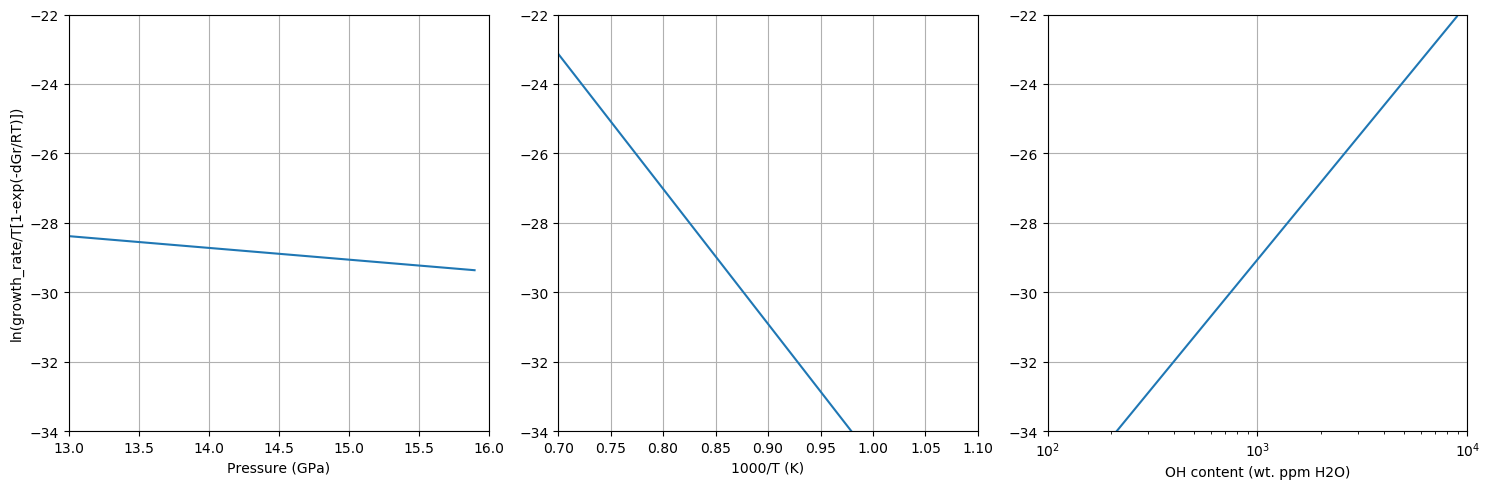

In [4]:
from matplotlib import gridspec
from scipy.integrate import cumtrapz

def growth_rate_hosoya_06_eq2_P1(P, T, Coh):
    """
    Calculate the growth rate following Equation 2 in Hosoya 2006.

    Parameters:
    - P (float): Pressure in Pascals.
    - T (float): Temperature in Kelvin.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float: The growth rate calculated using the given parameters.
    """
    R = 8.31446  # J / mol*K, universal gas constant

    # Constants based on Hosoya 2006
    A = np.exp(-18.0)  # m s-1 wt.ppmH2O^(-3.2)
    n = 3.2
    dHa = 274.0e3  # J / mol, activation enthalpy
    Vstar = 3.3e-6  # m^3 / mol, activation volume

    growth_rate_part = A * Coh**n * np.exp(-(dHa + P * Vstar) / (R * T))

    return growth_rate_part


def growth_rate_hosoya_06_eq2_metastable(P, P_eq, T, Coh):
    """
    Calculate growth rate using Equation 2 from Hosoya 2006 for metastable conditions.

    Parameters:
    - P (float or ndarray): Actual pressure (Pa).
    - P_eq (float or ndarray): Equilibrium pressure (Pa).
    - T (float or ndarray): Temperature (K).
    - Coh (float): Water concentration (wt.ppm H2O).

    Returns:
    - float or ndarray: Growth rate for the given conditions.
    """
    if type(T) in [float, np.float64]:
        if Ps > P_eq:
            growth_rate = growth_rate_hosoya_06_eq2(P, P_eq, T, Coh)
        else:
            growth_rate = 0.0
    elif type(T) == np.ndarray:
        assert P.shape == T.shape
        assert P_eq.shape == T.shape
        growth_rate = np.zeros(T.shape)
        mask = (P > P_eq)  # Check metastable condition
        growth_rate[mask] = growth_rate_hosoya_06_eq2(P[mask], P_eq[mask], T[mask], Coh)
    else:
        raise TypeError("T must be float or ndarray")
    return growth_rate


def growth_rate_hosoya_06_eq2(P, P_eq, T, Coh):
    """
    Calculate the growth rate following Equation 2 in Hosoya 2006, considering 
    pressure and temperature variations.

    Parameters:
    - P (float or np.ndarray): Pressure in Pascals.
    - P_eq (float or np.ndarray): Equilibrium pressure in Pascals.
    - T (float or np.ndarray): Temperature in Kelvin.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float or np.ndarray: The growth rate for each pressure point.
    """
    R = 8.31446  # J / mol*K, universal gas constant
    dV_ol_wd = 2.4e-6  # m^3 / mol, difference in volume between phases

    # Determine growth rate based on pressure type (float or array)
    if type(P) in [float, np.float64]:
        if P > P_eq:
            dGr = dV_ol_wd * (P - P_eq)
            growth_rate = growth_rate_hosoya_06_eq2_P1(P, T, Coh) * T * (1 - np.exp(-dGr / (R * T)))
        else:
            growth_rate = 0.0
    elif type(P) == np.ndarray:
        growth_rate = np.zeros(P.shape)
        mask = P > P_eq
        Pm = P[mask]
        Tm = T[mask]
        dGr = dV_ol_wd * (Pm - P_eq[mask])
        growth_rate[mask] = growth_rate_hosoya_06_eq2_P1(Pm, Tm, Coh) * Tm * (1 - np.exp(-dGr / (R * Tm)))
    else:
        raise TypeError("P must be float or ndarray")

    return growth_rate


def timescale_hosoya_06(P, P_eq, growth_rate, Coh):
    """
    Calculate the critical time scale for phase transition kinetics.

    Parameters:
    - P (float): Pressure in Pascals.
    - P_eq (float): Equilibrium pressure in Pascals.
    - growth_rate (float): Growth rate in m/s.
    - Coh (float): Concentration of water in weight parts per million (wt.ppm H2O).

    Returns:
    - float: The critical timescale in seconds.
    """
    R = 8.31446  # J / mol*K, universal gas constant
    dV_ol_wd = 2.4e-6  # m^3 / mol, difference in volume between phases

    # Constants for calculation
    A = np.exp(-18.0)  # m s-1 wt.ppmH2O^(-3.2)
    A_dot = A * dV_ol_wd / R
    n = 3.2
    dHa = 274.0e3  # J / mol, activation enthalpy
    Vstar = 3.3e-6  # m^3 / mol, activation volume

    Tcr = (dHa + P * Vstar) / R / (np.log(A_dot * Coh**n * (P - P_eq) / growth_rate))

    return Tcr

def MO_Vfraction_classic(growth_rates, ts, da0):

    # Compute cumulative integral of growth rates over time
    integral = np.zeros(growth_rates.shape)  # Initialize integral
    integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral

    # Calculate transformed volume fraction
    S = 3.35 / da0  # Surface area per unit volume (1/m)
    V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction

    return V


plot_hosoya_06 = True

if plot_hosoya_06:

    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate_part = growth_rate_hosoya_06_eq2_P1(Ps, T, Coh)
    ax.plot(Ps / 1e9, np.log(growth_rate_part))  # Pressure in GPa
    ax.grid()
    ax.set_xlim([13.0, 16.0])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("ln(growth_rate/T[1-exp(-dGr/RT)])")

    # Plot growth rate vs Temperature
    ax = fig.add_subplot(gs[0, 1])
    T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    Ts = 1000.0 / T_invert  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate_part = growth_rate_hosoya_06_eq2_P1(P, Ts, Coh)
    ax.plot(T_invert, np.log(growth_rate_part))
    ax.grid()
    ax.set_xlim([0.7, 1.1])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("1000/T (K)")

    # Plot growth rate vs OH content
    ax = fig.add_subplot(gs[0, 2])
    T = 900 + 273.15  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    growth_rate_part = growth_rate_hosoya_06_eq2_P1(P, T, Cohs)
    ax.semilogx(Cohs, np.log(growth_rate_part))
    ax.grid()
    ax.set_xlim([10**2, 10**4])
    ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("OH content (wt. ppm H2O)")


We also plot the values of grow rate for comparison

/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


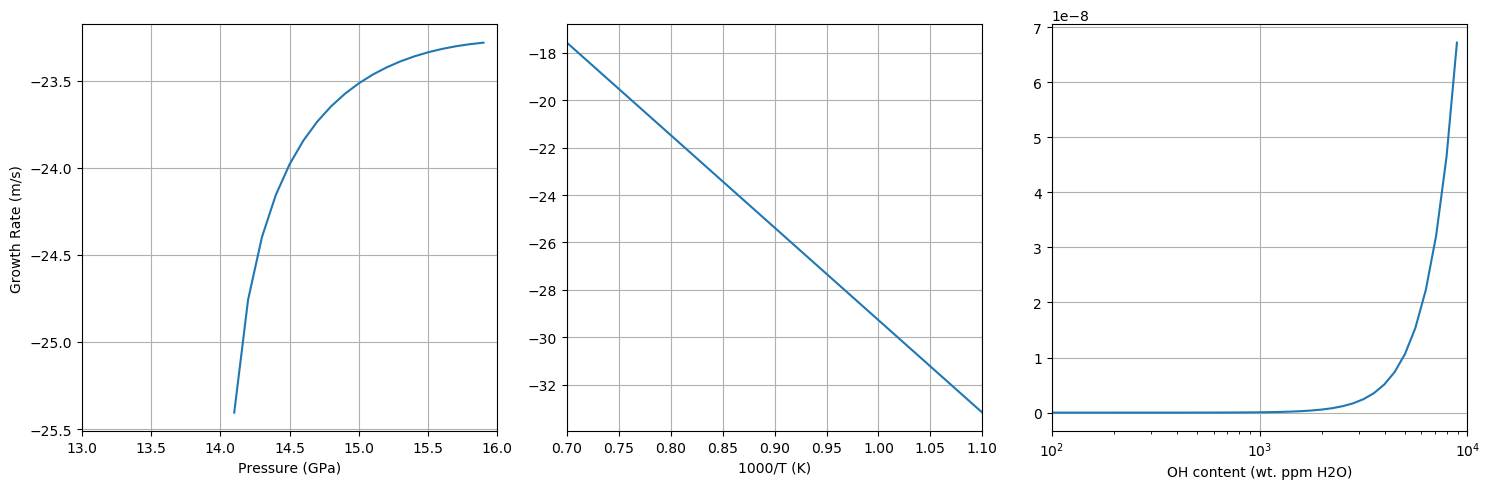

In [5]:
if plot_hosoya_06:

    year = 365.0 * 24.0 * 3600.0  # Seconds in one year

    # Parameters for equilibrium at the 410 km depth phase boundary
    T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
    cl_410 = 4e6  # Clapeyron slope (Pa/K)
    P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)

    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    Ts = np.full(Ps.shape, T)
    Ps_eq = np.full(Ps.shape, P_410)
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate = growth_rate_hosoya_06_eq2(Ps, Ps_eq, Ts, Coh)
    # growth_rate_part = growth_rate_hosoya_06_eq2_P1(Ps, T, Coh)

    ax.plot(Ps/1e9, np.log(growth_rate))
    ax.grid()
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("Growth Rate (m/s)")
    ax.set_xlim([13.0, 16.0])


    # Plot growth rate vs Temperature
    ax = fig.add_subplot(gs[0, 1])
    T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    Ts = 1000.0 / T_invert  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    Ps = np.full(Ts.shape, P)
    Ps_eq = np.full(Ps.shape, P_410)
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    growth_rate = growth_rate_hosoya_06_eq2(Ps, Ps_eq, Ts, Coh)
    ax.plot(T_invert, np.log(growth_rate))
    ax.grid()
    ax.set_xlim([0.7, 1.1])
    # ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("1000/T (K)")
    # ax.set_ylabel("Growth Rate (m/s)")


    # Plot growth rate vs OH content
    ax = fig.add_subplot(gs[0, 2])
    T = 900 + 273.15  # Temperature in Kelvin
    P = 15e9  # Pressure in Pascals
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    Ts = np.full(Cohs.shape, T)
    Ps = np.full(Cohs.shape, P)
    Ps_eq = np.full(Cohs.shape, P_410)
    growth_rate = growth_rate_hosoya_06_eq2(Ps, Ps_eq, Ts, Cohs)
    # growth_rate_part = growth_rate_hosoya_06_eq2_P1(P, T, Cohs)
    ax.semilogx(Cohs, growth_rate)
    ax.grid()
    ax.set_xlim([10**2, 10**4])
#     ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("OH content (wt. ppm H2O)") 

### Kubo et al., 2009

#### Interpolation and Visualization of Temperature Profile

This section of the notebook focuses on loading, interpolating, and visualizing a temperature profile (their Fig. 2) based on depth from a CSV file.
They already include the latent heat release from the exthorthemic transition in the thermal model (Fig. 2).

##### Key Steps

1. **Data Loading**:
   - Reads the temperature profile from a CSV file (`kubo_2009_T_center.csv`).
   - The file is located in the `data_set` directory within the specified `base_dir`.

2. **Data Extraction**:
   - Extracts depth (in kilometers) and temperature (in degrees Celsius) columns from the loaded dataset.

3. **Interpolation**:
   - Uses `scipy.interpolate.interp1d` to create an interpolation function for the temperature profile.
   - Generates interpolated values for depths at 1 km intervals.

4. **Visualization**:
   - Plots the interpolated temperature profile, with depth on the x-axis and temperature on the y-axis.
   - Includes axis labels and a grid for improved clarity.

##### Assumptions and Requirements

- The CSV file must exist at the specified path, and its structure should include two columns: depth and temperature.
- The depth values should be sorted in ascending order for proper interpolation.

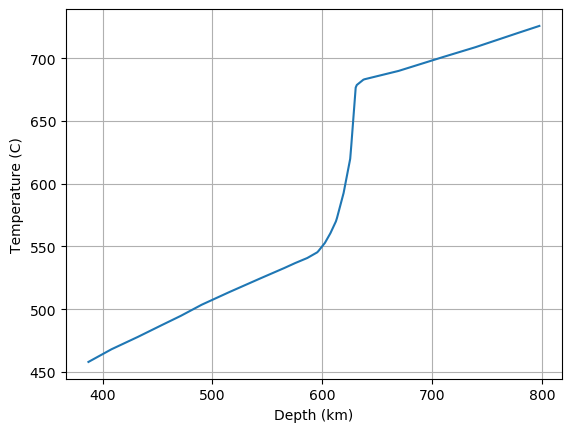

In [6]:
from scipy.interpolate import interp1d

reproduce_Kubo_2009 = True

if reproduce_Kubo_2009:

    # Load and plot the temperature profile from a CSV file.
    # Load temperature profile data from the file
    file_T_path = os.path.join(base_dir, "data_set", "kubo_2009_T_center.csv")
    assert(os.path.isfile(file_T_path))  # Ensure the file exists
    data_T = pd.read_csv(file_T_path)  # Read data using pandas

    # Extract depth and temperature columns
    depths = data_T.iloc[:, 0]  # Depth in kilometers
    Ts = data_T.iloc[:, 1]  # Temperature in degrees Celsius

    # Interpolate temperature profile
    T_interp = interp1d(depths, Ts)  # Create an interpolating function

    # Generate interpolated values
    depths1 = np.arange(depths.iloc[0], depths.iloc[-1], 1.0)  # Interpolated depths (km)
    Ts1 = T_interp(depths1)  # Interpolated temperatures (C)

    # Plot the interpolated temperature profile
    fig, ax = plt.subplots()
    ax.plot(depths1, Ts1)  # Depth vs. temperature plot

    # Add plot labels and grid
    ax.set_xlabel("Depth (km)")  # Label for x-axis
    ax.set_ylabel("Temperature (C)")  # Label for y-axis
    ax.grid()  # Add grid for better visualization


#### This section calculates and visualizes two types of temperature dependencies in their Fig. 4

1. Non-equilibrium temperature (\( T_{NE} \)) as a function of overpressure.
2. Grain size-dependent temperature (\( T_{GN} \)) as a function of grain size.

##### Equation for V

$V = 1 - exp\left[-2S \int_{0}^t \dot{x}\left(\tau\right)d\tau\right]$

##### Key Steps

1. **Non-equilibrium Temperature ($T_{NE}$)**:
   - Computes $T_{NE}$ for 1000 ppm and 100 ppm water concentrations.
   - Uses an overpressure range ($\Delta P$) from $0.01 \, \text{GPa}$ to $1.0 \, \text{GPa}$.
   - Subduction velocity ($v_{sub}$) and timescale ($t_{sub}$) are used to estimate the growth rate.
   - Visualized as $T_{NE}$ versus overpressure in a log-log plot.

2. **Grain Size-dependent Temperature ($T_{GN}$)**:
   - Computes $T_{GN}$ for 1000 ppm and 100 ppm water concentrations.
   - Uses a grain size range ($d$) from $10^{-6} \, \text{m}$ to $10^{-1} \, \text{m}$.
   - Grain size-dependent growth rate ($v_{GN}$) is calculated using a fixed subduction timescale ($t_{sub}$).
   - Visualized as $T_{GN}$ versus grain size in a log-log plot.

##### Constants and Assumptions

- **Year Conversion**: $1 \, \text{year} = 365 \times 24 \times 3600 \, \text{s}$
- **Equilibrium Conditions**:
  - Equilibrium temperature: $T_{eq,410} = 1760 \, \text{K}$
  - Clapeyron slope: $c_{l,410} = 4 \times 10^6 \, \text{Pa/K}$
  - Equilibrium pressure: $P_{410} = 14 \, \text{GPa}$
- **Subduction Properties**:
  - Grain size: $d = 5 \times 10^{-3} \, \text{m}$
  - Subduction velocity: $v_{sub} = 0.1 / \text{year}$
  - Subduction timescale: $t_{sub} = 10^5 \, \text{years}$

##### Additional notes
* Note their ol-wd curves references the Hosoya 2005 paper, while the post-spinel curve references the Kubo et al., 2002a, 2008 paper.
* S is the area of grain-boundary of parent phase (=3.35/d), d is the grain size of the parental olivine, assuming equidimensional grains (tetrakaidecahedra) [Cahn, 1956]. Note this seems the only place the parental grain size is needed.
* d is assumed to 5 mm in their figure 3.
* tsub, the subduction timescale, is based on $v_{sub}t_{sub} = 10 km$, thus a velocity of 10 cm yields a timescale of ${10}^5$ years.


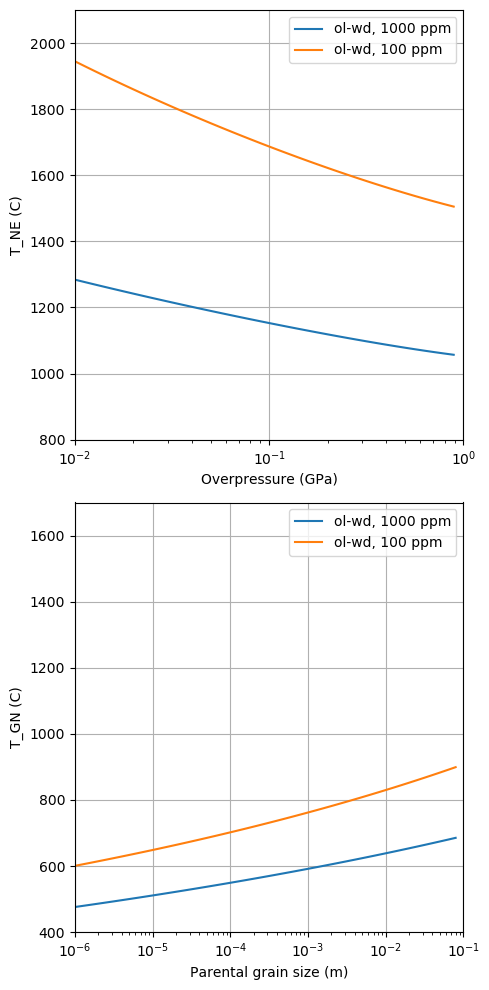

In [7]:
if reproduce_Kubo_2009:

    year = 365.0 * 24.0 * 3600.0  # Seconds in one year

    # Parameters for equilibrium at the 410 km depth phase boundary
    T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
    cl_410 = 4e6  # Clapeyron slope (Pa/K)
    P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)

    # Create a figure with two subplots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Figure 4a: T_NE (non-equilibrium temperature) vs. overpressure ----
    ax = fig.add_subplot(gs[0, 0])

    P_eq = P_410  # Equilibrium pressure (Pa)
    lndP = np.arange(-2.0, 0.0, 0.05)  # Logarithmic overpressure range (log10 GPa)
    dP = 10**lndP * 1e9  # Overpressure range (Pa)
    P = P_eq + dP  # Actual pressure range (Pa)
    d = 5e-3  # Grain size (m)
    v_sub = 0.1 / year  # Subduction velocity (m/s)
    t_sub = 1e5 * year  # Subduction timescale (s)
    growth_rate_NE = v_sub  # Growth rate for non-equilibrium

    # Calculate non-equilibrium temperature timescale (T_NE) for 1000 ppm water
    ts_NE = timescale_hosoya_06(P, P_eq, growth_rate_NE, 1000.0)
    ax.semilogx(dP / 1e9, ts_NE - 273.15, label="ol-wd, 1000 ppm")  # Plot curve for 1000 ppm

    # Calculate T_NE for 100 ppm water
    ts_NE_coh100 = timescale_hosoya_06(P, P_eq, growth_rate_NE, 100.0)
    ax.semilogx(dP / 1e9, ts_NE_coh100 - 273.15, label="ol-wd, 100 ppm")  # Plot curve for 100 ppm

    # Configure subplot
    ax.grid()
    ax.legend()
    ax.set_xlim([1e-2, 1.0])  # Overpressure range (GPa)
    ax.set_ylim([800, 2100.0])  # Temperature range (°C)
    ax.set_xlabel("Overpressure (GPa)")
    ax.set_ylabel("T_NE (C)")

    # ---- Figure 4b: T_GN (grain size-dependent temperature) vs. grain size ----
    ax = fig.add_subplot(gs[1, 0])

    logds = np.arange(-6, -1, 0.1)  # Logarithmic grain size range
    ds = 10**logds  # Grain size range (m)
    growth_rate_GN = ds / t_sub  # Grain size-dependent growth rate (m/s)
    dP = 0.5e9  # Overpressure (Pa)
    P = P_eq + dP  # Pressure for grain size calculations (Pa)

    # Calculate grain size-dependent temperature timescale (T_GN) for 1000 ppm water
    ts_GN = timescale_hosoya_06(P, P_eq, growth_rate_GN, 1000.0)
    ax.semilogx(ds, ts_GN - 273.15, label="ol-wd, 1000 ppm")  # Plot curve for 1000 ppm

    # Calculate T_GN for 100 ppm water
    ts_GN_coh100 = timescale_hosoya_06(P, P_eq, growth_rate_GN, 100.0)
    ax.semilogx(ds, ts_GN_coh100 - 273.15, label="ol-wd, 100 ppm")  # Plot curve for 100 ppm

    # Configure subplot
    ax.grid()
    ax.legend()
    ax.set_xlim([1e-6, 1e-1])  # Grain size range (m)
    ax.set_ylim([400, 1700.0])  # Temperature range (°C)
    ax.set_xlabel("Parental grain size (m)")
    ax.set_ylabel("T_GN (C)")


#### FIgure 5: Nucleation and Growth Visualization

##### Key Steps

1. **Parameters**:
   - Temperature (\(T\)) and pressure (\(P\)) profiles are calculated for depths from 400 km to 700 km.
   - Grain sizes (\(d\)) are set to \(5 \times 10^{-3} \, \text{m}\) for grain-boundary nucleation and \(5 \times 10^{-5} \, \text{m}\) for intracrystalline nucleation.

2. **Growth Rates**:
   - Growth rates are computed using metastable conditions for varying water concentrations (\(C_{OH}\)).

3. **Transformed Volume Fractions**:
   - The cumulative transformed volume (\(V\)) is calculated as:
     \[
     V = 1 - \exp(-2.0 \cdot S \cdot \text{integral})
     \]
   - \(S\) is the surface area per unit volume.

4. **Plots**:
   - **Grain-boundary nucleation**: \(V\) is plotted against depth for water concentrations of 250, 500, and 750 wt.ppm.
   - **Intracrystalline nucleation**: \(V\) is plotted against depth for water concentrations of 50, 150, and 250 wt.ppm.

##### Additional Notes
* They seem to not include the positive feedback from the latentheat, as they note "Previous studies have revealed that the G-type olivine–ringwoodite transformation quickly completes when it proceeds to the critical volume fraction of 5–10 vol.% due to the positive feedback of the latent heat release (e.g., Rubie and Ross, 1994; Kirby et al., 1996; Mosenfelder et al., 2001)."
* The transformed volume by intracrystallion nucleation should always be bigger, since it assumes a smaller parental grain size, thus a larger nucleation area S.
* Note the slight differences of our curves to theirs (e.g. the 250 wt.ppm H2O curve in figure 5 a, at 700 depth, theirs is around 0.85, while ours is around 0.95)

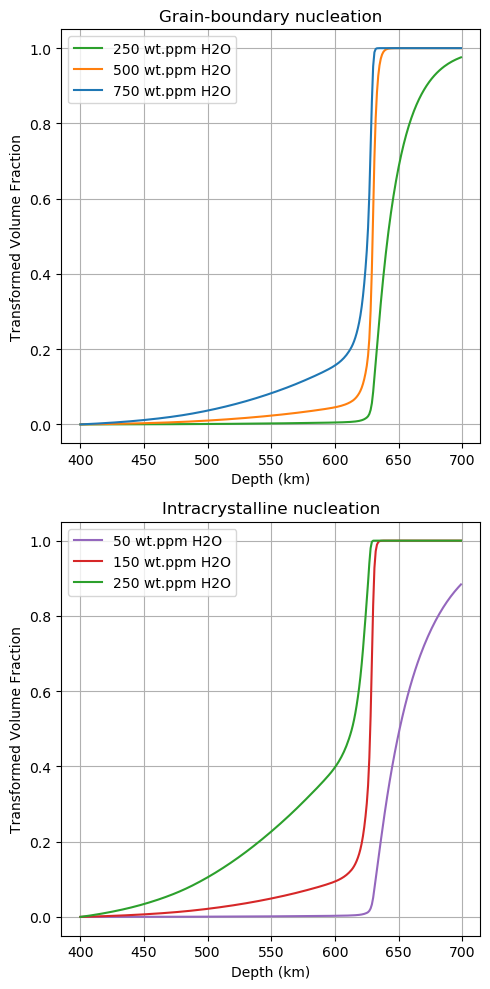

In [8]:
# figure 5: Grain-boundary and intracrystalline nucleation plots

if reproduce_Kubo_2009:

    from scipy.integrate import cumtrapz
    from matplotlib import gridspec

    # Retrieve the default color cycle for consistent plot coloring
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Reference parameters from Hosoya 2005
    T660 = 873.0  # Temperature at 660 km depth (K)
    Tgrad = 0.6 / 1e3  # Temperature gradient (K/m)
    dPdh = 30e6 / 1e3  # Pressure gradient (Pa/m)
    v_sub = 0.095 / year  # Subduction velocity (m/s)
    depth0 = 400e3  # Initial depth for calculations (m)

    # Define depth, temperature, and pressure profiles
    depths = np.arange(depth0, 700e3, 1e3)  # Depths from 400 to 700 km (m)
    ts = (depths - depth0) / v_sub  # Time required for subduction to each depth (s)
    Ts = T_interp(depths / 1e3) + 273.15  # Temperature interpolated and converted to K
    Ps = (depths - 410e3) * dPdh + P_410  # Pressure profile (Pa)

    # Equilibrium pressure and corresponding depths
    Ps_eq = (Ts - T_eq_410) * cl_410 + P_410  # Equilibrium pressure (Pa)
    depths_eq = 410e3 + (Ts - T_eq_410) * cl_410 / dPdh  # Equilibrium depth (m)


    # Create a figure for nucleation plots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Plot 1: Grain-boundary nucleation ----
    ax = fig.add_subplot(gs[0, 0])

    d_ol = 5e-3  # Grain size for olivine (m)
    S = 3.35 / d_ol  # Surface area per unit volume (1/m)

    # Calculate and plot for different water concentrations
    for Coh, color, label in [(250.0, default_colors[2], "250 wt.ppm H2O"),
                            (500.0, default_colors[1], "500 wt.ppm H2O"),
                            (750.0, default_colors[0], "750 wt.ppm H2O")]:
        growth_rates = growth_rate_hosoya_06_eq2_metastable(Ps, Ps_eq, Ts, Coh)
        integral = np.zeros(depths.shape)  # Initialize integral
        integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral
        V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction
        ax.plot(depths / 1e3, V, label=label, color=color)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Transformed Volume Fraction")
    ax.set_title("Grain-boundary nucleation")

    # ---- Plot 2: Intracrystalline nucleation ----
    ax = fig.add_subplot(gs[1, 0])

    d_ol = 5e-5  # Grain size for olivine (m)
    S = 3.35 / d_ol  # Surface area per unit volume (1/m)

    # Calculate and plot for different water concentrations
    for Coh, color, label in [(50.0, default_colors[4], "50 wt.ppm H2O"),
                            (150.0, default_colors[3], "150 wt.ppm H2O"),
                            (250.0, default_colors[2], "250 wt.ppm H2O")]:
        growth_rates = growth_rate_hosoya_06_eq2_metastable(Ps, Ps_eq, Ts, Coh)
        integral = np.zeros(depths.shape)  # Initialize integral
        integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral
        V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction
        ax.plot(depths / 1e3, V, label=label, color=color)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Transformed Volume Fraction")
    ax.set_title("Intracrystalline nucleation")

    plt.show()


#### Figure 7: Grain size evolution and viscosity calculation

##### Key Steps

1. **Viscosity Calculation**:
   - The flow law from *Kubo et al., 2008* is used to compute viscosity:
     $$
     \eta = \eta_0 \exp\left(\frac{T_0 - T}{a} + \frac{z}{b} - \left(\frac{z}{c}\right)^2\right)
     $$
     - Parameters:
       - $T$: Temperature (K).
       - $z$: Depth (m).
       - $\eta_0$, reference viscosity.
       - $T_0 = 1873.15 \, \text{K}$, reference temperature.
       - $a = 131.3 \, \text{K}$, $b = 150 \, \text{km}$, $c = 1086 \, \text{km}$.

2. **Grain Size Profiles**:
   - Initial grain sizes:
     - Olivine: $d_{a0} = 5 \, \text{mm}$.
     - Wadleyite: $d_{b0} = 0.1 \, \text{mm}$.
   - Grain size evolution is based on the transformed volume fraction $V$:
     $$
     V = 1 - \exp(-2.0 \cdot S \cdot \text{integral})
     $$
     - $S = \frac{3.35}{d_{a0}}$: Surface area per unit volume (1/m).
     - The integral accumulates growth rates over time.

3. **Switching Conditions**:
   - Grain size switches from olivine to wadleyite when $V > 0.5$.

##### Constants and Assumptions

- **Depth Range**: 400 km to 700 km.
- **Water Concentration**: $C_{OH} = 500 \, \text{wt.ppm}$.
- **Subduction Velocity**: $v_{\text{sub}} = 0.095 \, \text{m/s}$.

##### Additional Notes

* Current state: I failed to reproduce the grain size evolution. I assumed the grain size to be the integration of growth rate, this might cause the problem. It might also be the case there is something wrong in the grain growth mechanism.
* For the viscosity, they used the Peierls creep in Karato et al., 2001 and Diffusion creep in Frost and Ashby, I didn't go further into these references.

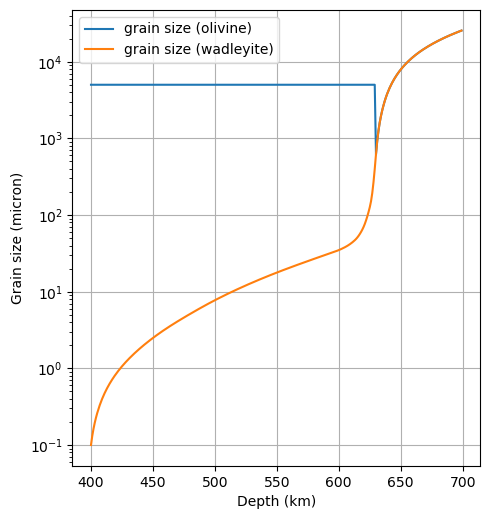

In [9]:
# Figure 7
def flow_law_Kubo_2008(T, z):
    """
    Compute viscosity using the flow law from Kubo et al. 2008.

    Parameters:
    - T (float): Temperature (K).
    - z (float): Depth (m).

    Returns:
    - float: Viscosity (Pa·s).
    """
    # Constants for the flow law
    a = 131.3  # Temperature scaling factor (K)
    b = 150.0e3  # Depth linear term (m)
    c = 1086e3  # Depth quadratic term (m)
    T0 = 1600 + 273.15  # Reference temperature (K)
    eta0 = 1e-19  # Reference viscosity (Pa·s)

    # Calculate viscosity
    eta = eta0 * np.exp((T0 - T) / a + z / b - (z / c)**2.0)

    return eta

if reproduce_Kubo_2009:

    # Initial parameters
    da0 = 5e-3  # Initial grain size for olivine (m)
    db0 = 1e-7  # Initial grain size for wadleyite (m)
    Coh = 500  # Water concentration (wt.ppm H2O)

    # Define depth, temperature, and pressure profiles
    depths = np.arange(depth0, 700e3, 1e3)  # Depths from 400 to 700 km (m)
    ts = (depths - depth0) / v_sub  # Subduction time to each depth (s)
    Ts = T_interp(depths / 1e3) + 273.15  # Temperature interpolated and converted to K
    Ps = (depths - 410e3) * dPdh + P_410  # Pressure profile (Pa)

    # Equilibrium pressure and corresponding depths
    Ps_eq = (Ts - T_eq_410) * cl_410 + P_410  # Equilibrium pressure (Pa)

    # Initial grain size profile
    ds = np.full(depths.size, da0)  # Start with constant grain size (m)

    # Calculate growth rates under metastable conditions
    growth_rates = growth_rate_hosoya_06_eq2_metastable(Ps, Ps_eq, Ts, Coh)

    # Compute cumulative integral of growth rates over time
    integral = np.zeros(depths.shape)  # Initialize integral
    integral[1:] = cumtrapz(growth_rates, ts)  # Cumulative integral

    # Calculate transformed volume fraction
    S = 3.35 / da0  # Surface area per unit volume (1/m)
    V = 1 - np.exp(-2.0 * S * integral)  # Transformed volume fraction

    # Update grain size profile
    db = db0 + integral  # Wadleyite grain size evolution (m)

    # Switch grain size based on transformed volume fraction
    mask = (V > 0.5)  # Condition where transformed fraction exceeds 50%
    ds[mask] = db[mask]  # Update grain size for transformed regions

    # Create a figure for grain size plots
    fig = plt.figure(tight_layout=True, figsize=(5, 10))
    gs = gridspec.GridSpec(2, 1)

    # ---- Plot 1: Grain Size vs Depth ----
    ax = fig.add_subplot(gs[0, 0])
    ax.semilogy(depths / 1e3, ds / 1e-6, label="grain size (olivine)")  # Grain size (micron)
    ax.semilogy(depths / 1e3, db / 1e-6, label="grain size (wadleyite)")  # Wadleyite grain size (micron)

    # Configure plot
    ax.grid()
    ax.legend()
    ax.set_xlabel("Depth (km)")
    ax.set_ylabel("Grain size (micron)")


### Tetzlaff & Schmeling 09

#### Import their temperature profile in figure 1

Here I only plot their curves with no latent heat effects

#### Check the value of their growth rate

Note using their documented values results in a growth rate too low (compared to the same plot in the Hosoya paper). This would in turn result in a 0 fraction of wb contents.

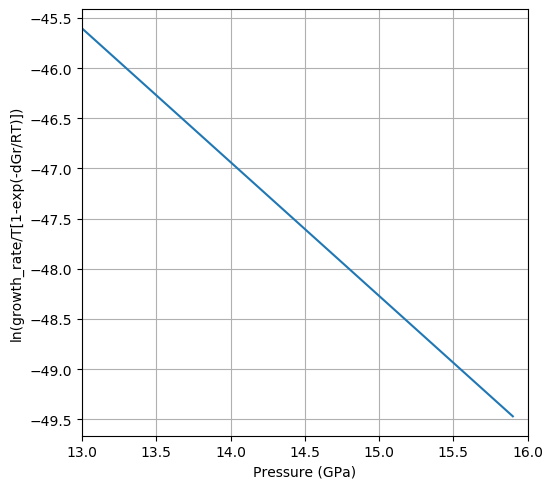

In [10]:
from matplotlib import gridspec

def Tprofile_TS09_fig1_warm(depths):

    depth0 = 370.28496710020283e3; T0 = 684.1150723737485 + 273.15 # m, K
    depth1 = 698.9440717961519e3; T1 = 912.82119751198 + 273.15 # m, K

    Ts = (depths - depth0) / (depth1 - depth0) * T1 + (depths - depth1) / (depth0 - depth1) * T0

    return Ts

def Tprofile_TS09_fig1_cold(depths):

    depth0 = 352.5238657769547e3; T0 = 472.0332858291416 + 273.15 # m, K
    depth1 = 694.6273339699476e3; T1 = 711.0368878272202 + 273.15 # m, K

    Ts = (depths - depth0) / (depth1 - depth0) * T1 + (depths - depth1) / (depth0 - depth1) * T0

    return Ts

def growth_rate_tetzlaff_schmeling_09(Ts, Ps, depths, depth_eq):

    R = 8.31446  # J / mol*K, universal gas constant
    k0 = 2005.0
    # k0 = 20**5.0
    dHa = 350e3 # j / mol
    Va = 1.3e-5 # m^3 / mol
    Lz = 0.5393
    dGr = Lz * (depths - depth_eq) # consistent with their enthalpy calculation
    growth_rate = k0 * Ts * np.exp(-(dHa + Ps * Va) / R / Ts) * (1 - np.exp(-dGr / R / Ts))

    return growth_rate


    
def TS09_check():
    
    R = 8.31446  # J / mol*K, universal gas constant
    T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
    cl_410 = 4e6  # Clapeyron slope (Pa/K)
    P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)
    dPdh = 30e6/1e3 # Pa/m

    # Visualization of growth rate variations
    fig = plt.figure(tight_layout=True, figsize=(15, 5))
    gs = gridspec.GridSpec(1, 3)

    # Plot growth rate vs Pressure
    ax = fig.add_subplot(gs[0, 0])
    T = 900 + 273.15  # Temperature in Kelvin
    Ps = np.arange(13e9, 16e9, 0.1e9)  # Pressure range in Pascals
    depths = (Ps - P_410) / dPdh + 410e3
    depths_eq = 410e3 + (T - T_eq_410) * cl_410 / dPdh
    
    Lz = 0.5393
    dGr = Lz * (depths - depths_eq) # consistent with their enthalpy calculation
    growth_rate = growth_rate_tetzlaff_schmeling_09(T, Ps, depths, depths_eq)
    # Coh = 1000.0  # Concentration of water in wt.ppm H2O
    ax.plot(Ps / 1e9, np.log(growth_rate/(T*(1-np.exp(-dGr/R/T)))))  # Pressure in GPa
    ax.grid()
    ax.set_xlim([13.0, 16.0])
    # ax.set_ylim([-34.0, -22.0])
    ax.set_xlabel("Pressure (GPa)")
    ax.set_ylabel("ln(growth_rate/T[1-exp(-dGr/RT)])")

    # # Plot growth rate vs Temperature
    # ax = fig.add_subplot(gs[0, 1])
    # T_invert = np.arange(0.7, 1.1, 0.01)  # 1000/T range
    # Ts = 1000.0 / T_invert  # Temperature in Kelvin
    # P = 15e9  # Pressure in Pascals
    # Coh = 1000.0  # Concentration of water in wt.ppm H2O
    # growth_rate_part = growth_rate_hosoya_06_eq2_P1(P, Ts, Coh)
    # ax.plot(T_invert, np.log(growth_rate_part))
    # ax.grid()
    # ax.set_xlim([0.7, 1.1])
    # ax.set_ylim([-34.0, -22.0])
    # ax.set_xlabel("1000/T (K)")

    # # Plot growth rate vs OH content
    # ax = fig.add_subplot(gs[0, 2])
    # T = 900 + 273.15  # Temperature in Kelvin
    # P = 15e9  # Pressure in Pascals
    # log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    # Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O
    # growth_rate_part = growth_rate_hosoya_06_eq2_P1(P, T, Cohs)
    # ax.semilogx(Cohs, np.log(growth_rate_part))
    # ax.grid()
    # ax.set_xlim([10**2, 10**4])
    # ax.set_ylim([-34.0, -22.0])
    # ax.set_xlabel("OH content (wt. ppm H2O)")


TS09_check()

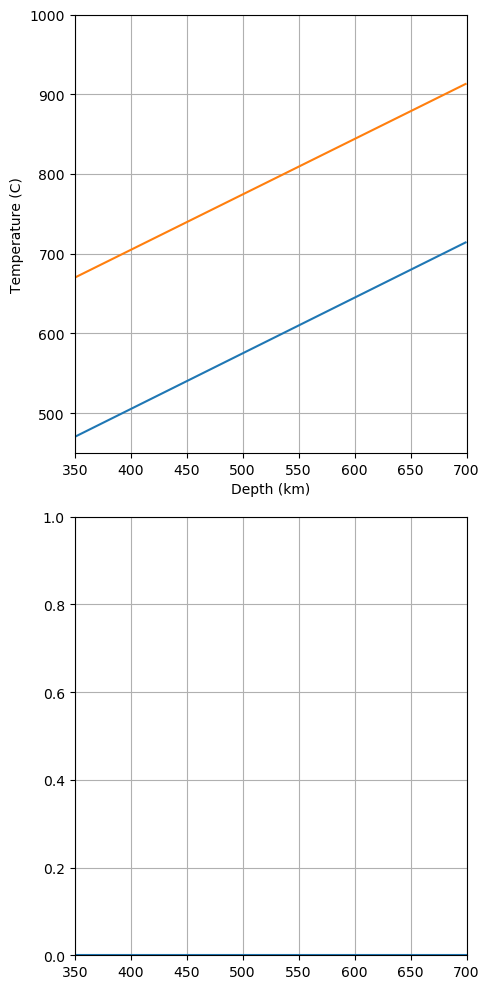

In [11]:
q_depths = np.arange(300e3, 700e3, 1e3)

q_Ts_warm = Tprofile_TS09_fig1_warm(q_depths)
q_Ts_cold = Tprofile_TS09_fig1_cold(q_depths)

fig = plt.figure(tight_layout=True, figsize=(5, 10))
gs = gridspec.GridSpec(2, 1)
ax = fig.add_subplot(gs[0, 0])

ax.plot(q_depths/1e3, q_Ts_cold - 273.15)
ax.plot(q_depths/1e3, q_Ts_warm - 273.15)

ax.set_xlim([350, 700])
ax.set_ylim([450, 1000])

ax.set_xlabel("Depth (km)")
ax.set_ylabel("Temperature (C)")

ax.grid()


# calculate MO kinetics

year = 365.0 * 24.0 * 3600.0  # Seconds in one year

# Parameters for equilibrium at the 410 km depth phase boundary
T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
cl_410 = 4e6  # Clapeyron slope (Pa/K)
P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)
dPdh = 30e6/1e3 # Pa/m
d_ol = 5e-3 # m
    
# Equilibrium pressure and corresponding depths
v_h = 0.05/year # m / s

q_ts = q_depths / v_h
q_Ps = (q_depths - 410e3)*dPdh + P_410
q_depths_eq_cold = 410e3 + (q_Ts_cold - T_eq_410) * cl_410 / dPdh  # Equilibrium depth (m)

q_growth_rate_cold = growth_rate_tetzlaff_schmeling_09(q_Ts_cold, q_Ps, q_depths, q_depths_eq_cold)
V_cold = MO_Vfraction_classic(q_growth_rate_cold, q_ts, d_ol)

# Plot the wd contents
ax1 = fig.add_subplot(gs[1, 0])

ax1.plot(q_depths/1e3, V_cold)
ax1.set_xlim([350, 700])
ax1.set_ylim([0.0, 1.0])

ax1.grid()


plt.show()

### Yoshioka_etal_2015

#### Equation (10): Nucleation Rate

##### Key Equation
The nucleation rate is expressed as:

$$
I(P, T) = K_0 T \exp\left(-\frac{\Delta G^*_{hom}}{k T}\right) \exp\left(-\frac{Q_a}{R T}\right)
$$

Activation energy for homogeneous nucleation (page 72) is defined as:

$$
\Delta G^*_{hom} = \frac{16 \pi \gamma^3}{3 (\Delta G_v + e)^2}
$$

1. **Constants**:
   - $K_0 = 3.54 \times 10^{38} \, s^{-1} \, m^{-2} \, K^{-1}$ (pre-exponential factor).
   - $k = 1.38 \times 10^{-23} \, J \, K^{-1}$ (Boltzmann constant).
   - $Q_a = 355 \, \text{kJ/mol}$ (activation energy for growth).
   - $R = 8.314 \, \text{J/mol/K}$ (universal gas constant).

2. **Assumptions**:
   - Surface energy $\gamma = 0.0506 \, J/m^2$, based on experimental studies (noted as questionable for further investigation).
   - Strain energy $e = 0$ (negligible for this model).
   - Homogeneous nucleation conditions apply.

##### Notes
- The value of $\gamma$ (surface energy) is flagged as **questionable** and may require validation through experimental or theoretical means. There is a value in their table 1 marked as "Shape factor and interfacial energy" which is with a different notation and is not used elsewhere in the paper. So this might be the value.
- The value of $G_v$ is this equation is in the unit of j / m^3, it follows that $G_v = \Delta P \Delta V$ in the free energy due to over pressure. So the $\Delta V$ has a unit of unit of 1, which means this value is the volume change percent. This is different from the value used in the other equation of grain growth marked as $G_r$, there we need a $\Delta V$ in terms of volume change per mol. To make these two values at least consistent to each other, we have:
$$\Delta V_{v} = \frac{\Delta V_{r}}{V_{initial}}$$
For this value of $V_{initial}$, I would try to use 140.69g/mol as M for olivine and density at 410 km of $\rho_{initial} = 4.0 g / {cm}^3$, so the value of $V_{initial} = 140.69 / 4.0 = 35.17 {cm}^3 / mol$
- This equation yields large magnitude variation, which could be seen from both the magnitude of $K_0$ (${10}^{38}$) and the fact that in the first exponential term the $G^*_{hom}$ starts from infinite when there is not overpressure (The $\Delta G_v$ in the denominator starts from 0.0). In terms of variations with P and T, we expect increase in value with both increasing T and increasing P.

In [12]:

def nucleation_rate_yoshioka_2015(T, P, delta_G_v, gamma=0.0506, K0=3.54e38, dH_a=344e3, V_star=4e-6, k=1.38e-23, R=8.314):
    """
    Compute the nucleation rate using Equation (10) from Yoshioka et al. (2015).
    
    Parameters:
    - T (float): Temperature in Kelvin.
    - P (float): Pressure in Pa
    - delta_G_v (float): Free energy change per volume in J/m^3.
    - gamma (float): Surface energy in J/m^2 (default: 0.0506).
    - K0 (float): Pre-exponential factor in s^-1 m^-2 K^-1 (default: 3.54e38).
    - Q_a (float): Activation energy for growth in J/mol (default: 355e3).
    - k (float): Boltzmann constant in J/K (default: 1.38e-23).
    - R (float): Universal gas constant in J/(mol*K) (default: 8.314).
    
    Returns:
    - I (float): Nucleation rate in s^-1 m^-2.
    """
    if type(delta_G_v) == float:
        assert(delta_G_v > 0.0)
    elif type(delta_G_v) == np.ndarray:
        assert(np.min(delta_G_v) > 0.0)

    # Compute the homogeneous nucleation activation energy
    delta_G_hom = (16 * np.pi * gamma**3) / (3 * (delta_G_v)**2)
    
    # Compute the nucleation rate
    Q_a = dH_a + P * V_star 
    I = K0 * T * np.exp(-delta_G_hom / (k * T)) * np.exp(-Q_a / (R * T))
    
    return I

#### Dimensionless time to reach site saturation

The equation for the dimensionless time $\tau_s$ in Equation 9 of the paper is:

$$\tau_s = \frac{\kappa}{D^2}\left(\frac{I(P, T) {Y(P, T)}^2 d_0}{6.7} \right)^{-1/3}$$

Where:
- $\kappa$: Thermal diffusivity.
- D: Thickness of the slab.
- $I(P, T)$: Nucleation rate as a function of pressure (P) and temperature (T).
- $Y(P, T)$: Growth rate as a function of pressure (P) and temperature (T).
- $d_0$: Grain size of olivine.

This equation describes the time required to reach site saturation during the phase transformation process, incorporating the kinetic effects of nucleation and growth on the transformation process

##### Notes

- The non-dimensionalization process make use of the time scale of thermal diffusion $ D^2 / \kappa $, this value is ${10}^{11}s$ for a slab of 100 km thick, which is about 300 Ma
- To compute the saturation time, convert the nucleation rate on unit surface area to the rate on unit volume.
- The nucleate rate start from a very small value near the equilibirum transform pressure and the saturation time is big. This is from assuming an 0 elastic energy. In other word, assuming some elastic energy will induce a slower nucleation rate and make it more important in the kinetics.
- I use a value of 4 MPa / K here for calculation of the MO kinetics, which might be bigger than the Cl for the pyrolite composition.
- The growth rate curve has a more complex dependence on P, T. It tends to first increase and then decrease with P. It also tends to increase transiently at small T. On the other hand, the nucleation rate increases with P, T and is not dependent on Coh.

In [13]:
def calculate_sigma_s(I_PT, Y_PT, d_0, **kwargs):
    """
    Calculate the dimensionless time (sigma_s) for the phase transformation process.

    Parameters:
    - I_PT (float): Nucleation rate as a function of pressure and temperature (s^-1 m^-3).
    - Y_PT (float): Growth rate as a function of pressure and temperature (m/s).
    - d_0 (float): Grain size of olivine (m).

    Returns:
    - sigma_s (float): Dimensionless time for site saturation.
    """
    kappa = kwargs.get("kappa", 1e-6) # Thermal diffusivity (m^2/s).
    D = kwargs.get("D", 100e3) # slab thickness
    # Compute the dimensionless time
    sigma_s = (kappa / D**2) * ((I_PT * Y_PT**2 * d_0) / 6.7)**(-1/3)
    return sigma_s


#### Plot the summary of nucleation rate, growth rate and saturation time

##### Note
* Both nucleation rate and growth rate are very small when P is close to the equilibrium value of P

/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log10
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in log10
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: divide by zero encountered in log10
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log10


Saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/plot_yoshioka_2015/Yoshioka_2015_rates_P_12.1GPa_T_984.3K.pdf


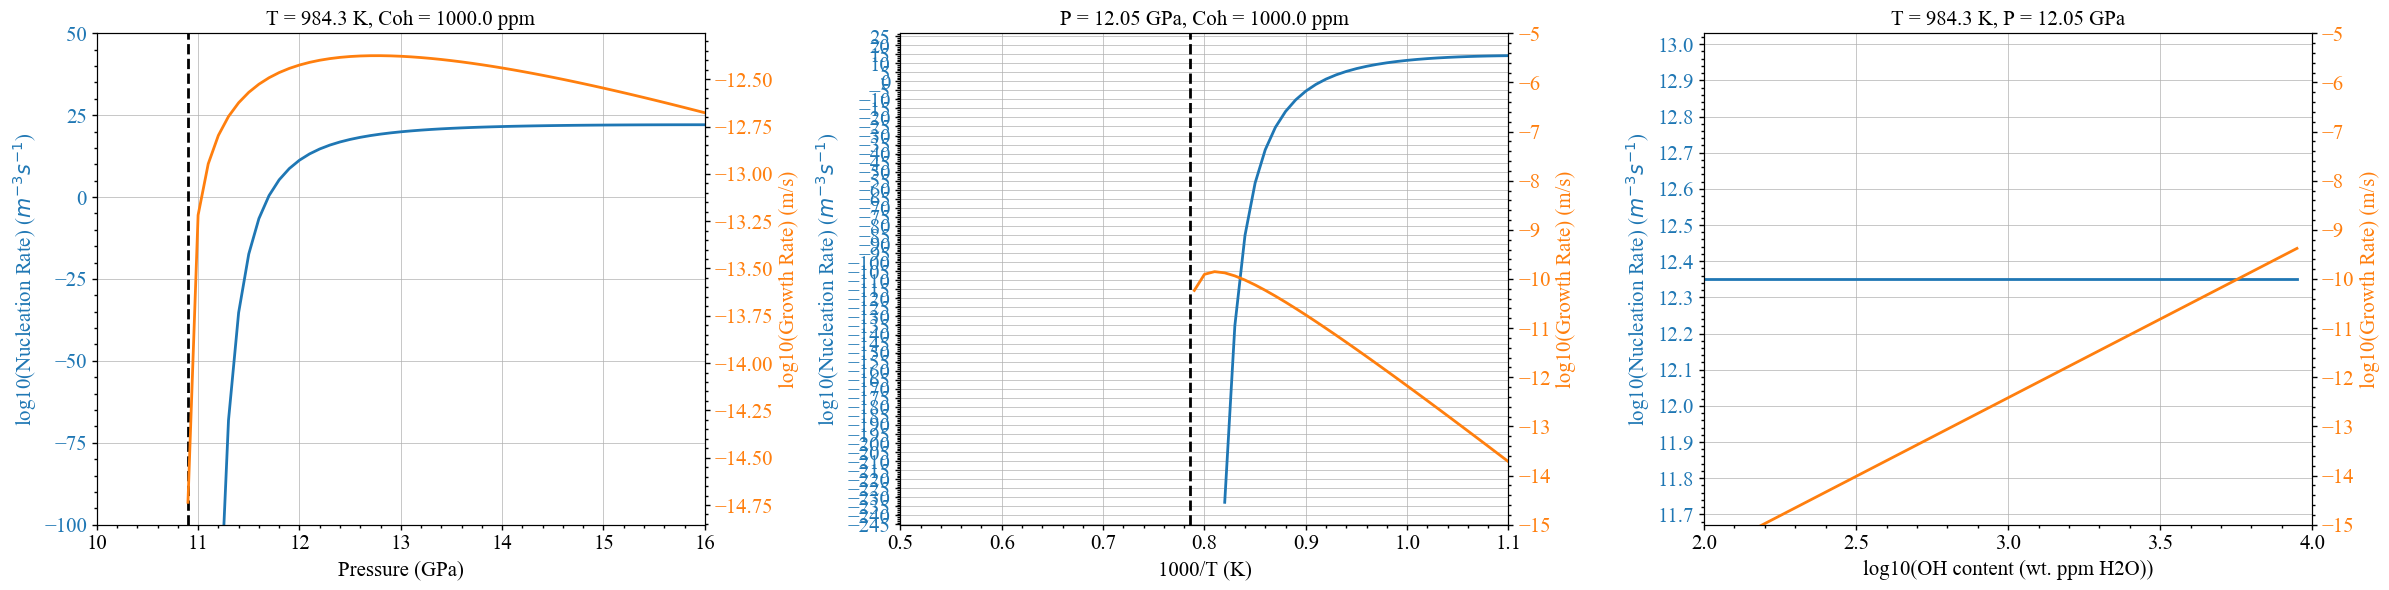

In [14]:
plot_yoshioka_2015 = True

if plot_yoshioka_2015:
    from matplotlib import rcdefaults
    from matplotlib.ticker import MultipleLocator

    # directory to save results
    o_dir = os.path.join(root_path, results_dir, "plot_yoshioka_2015")

    if not os.path.isdir(o_dir):
        os.mkdir(o_dir)
    
    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (10.0, 16.0)
    x_lim3 = (0.5, 1.1)
    x_lim5 = (2.0, 4.0)
    x_tick_interval = 1.0   # tick interval along x
    x_tick_interval3 = 0.1   # tick interval along x
    x_tick_interval5 = 0.5
    y_lim = (-100.0, 50.0)
    y_lim2 = (-11.0, -9.5)
    y_lim3 = (-50.0, -0.0)
    y_lim4 = (-15.0, -5.0)
    y_lim5 = (24.5, 25.5)
    y_lim6 = (-15.0, -5.0)
    y_tick_interval = 25.0  # tick interval along y
    y_tick_interval2 = 0.25  # tick interval along y
    y_tick_interval3 = 5.0
    y_tick_interval4 = 1.0
    y_tick_interval5 = 0.1
    y_tick_interval6 = 1.0
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    year = 365.0 * 24.0 * 3600.0  # Seconds in one year
    
    # constant T and P used in the plots 
    # T = 900 + 273.15  # Temperature in Kelvin
    # P = 14.5e9  # Pressure in Pascals

    # assign value of P near equilibrium (1.1053e10) will lead to small nucleation rate
    # assigning a slightly bigger value (1.2053e10) leads to fast transition
    # T = 9.8426e+02; P = 1.1053e10
    T = 9.8426e+02; P = 1.2053e10

    Coh = 1000.0  # Concentration of water in wt.ppm H2O

    kappa = 1e-6 # m^2/s
    D = 100e3 # m
    
    d0 = 0.01 # m, grain size of olivine

    # Parameters for equilibrium at the 410 km depth phase boundary
    T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
    cl_410 = 4e6  # Clapeyron slope (Pa/K)
    P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)

    dV_ol_wd = 2.4e-6  # m^3 / mol, difference in volume between phases
    V_initial = 35.17e-6 # m^3 / mol, for olivine, estimation at 410 km
    dV_ol_wd_v = dV_ol_wd / V_initial

    # Visualization of growth rate variations
    fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(3*8*scaling_factor, 6*scaling_factor))

    # Plot nondimentional time vs Pressure
    ax1 = axes[0]

    Ps = np.arange(10e9, 17e9, 0.1e9)  # Pressure range in Pascals
    Ts = np.full(Ps.shape, T)
    Ps_eq = P_410 + (Ts - T_eq_410)*cl_410
    # Ps_eq = np.full(Ps.shape, P_410)

    dGr_vs = dV_ol_wd_v * (Ps - Ps_eq)
    
    nucleation_rate_S = np.zeros(Ps.shape) # derive nucleation rate
    mask = Ps > Ps_eq
    nucleation_rate_S[mask] = nucleation_rate_yoshioka_2015(Ts[mask], Ps[mask], dGr_vs[mask])
    
    nucleation_rate = 6 * nucleation_rate_S / d0
    
    growth_rate = growth_rate_hosoya_06_eq2(Ps, Ps_eq, Ts, Coh)  # calculate growth rate

    sigma_s = calculate_sigma_s(nucleation_rate, growth_rate, d0)

    ax1.plot(Ps / 1e9, np.log10(nucleation_rate), label="Nucleation Rate", color=default_colors[0]) # Plot nucleation rate on ax1
    ax1.set_xlabel("Pressure (GPa)")
    ax1.set_ylabel(r"log10(Nucleation Rate) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax1.tick_params(axis='y', labelcolor=default_colors[0])
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)

    P_eq = P_410 + (T - T_eq_410)*cl_410
    ax1.axvline(x=P_eq / 1e9, color="black", linestyle="--", label=r"$P_{410}$") # Add a vertical line at P_410

    ax2 = ax1.twinx() # Create a secondary x-axis for growth rate
    ax2.plot(Ps / 1e9, np.log10(growth_rate), label="Growth Rate (log)", color=default_colors[1])
    ax2.set_ylabel("log10(Growth Rate) (m/s)", color=default_colors[1])
    ax2.tick_params(axis='y', labelcolor=default_colors[1])
    # ax2.set_ylim(y_lim2)

    ax1.set_title("T = %.1f K, Coh = %.1f ppm" % (T, Coh))

    ax1.grid()
    

    # Plot rates vs T
    ax3 = axes[1]
    
    T_invert = np.arange(0.5, 1.1, 0.01)  # 1000/T range
    Ts_1 = 1000.0 / T_invert  # Temperature in Kelvin
    
    Ps_eq_1 = P_410 + (Ts_1 - T_eq_410)*cl_410

    dGr_vs_1 = dV_ol_wd_v * (P - Ps_eq_1)
    Coh = 1000.0  # Concentration of water in wt.ppm H2O

    nucleation_rate_S1 = np.zeros(Ts_1.shape)

    mask = (P > Ps_eq_1)
    nucleation_rate_S1[mask] = nucleation_rate_yoshioka_2015(Ts_1[mask], P, dGr_vs_1[mask])
    
    nucleation_rate_1 = 6 * nucleation_rate_S1 / d0
    
    ax3.plot(T_invert, np.log10(nucleation_rate_1), color=default_colors[0])
    ax3.set_xlim(x_lim3)
    ax3.set_xlabel("1000/T (K)")
    ax3.set_ylabel(r"log10(Nucleation Rate) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax3.tick_params(axis='y', labelcolor=default_colors[0])

    # ax3.set_ylim(y_lim3)

    T_eq_1 = T_eq_410 + (P - P_410)/cl_410
    ax3.axvline(x=1000.0 / T_eq_1, color="black", linestyle="--", label=r"$T_{410}$") # Add a vertical line at P_410

    ax4 = ax3.twinx() # Plot growth rate vs Temperature
    
    Ps_1 = np.full(Ts_1.shape, P)
    # Ps_1_eq = np.full(Ps_1.shape, P_410)
    Ps_1_eq = P_410 + (Ts_1 - T_eq_410)*cl_410
    Coh = 1000.0  # Concentration of water in wt.ppm H2O
    
    growth_rate_1 = growth_rate_hosoya_06_eq2(Ps_1, Ps_1_eq, Ts_1, Coh)
    ax4.plot(T_invert, np.log10(growth_rate_1), color=default_colors[1])
    ax4.set_ylabel("log10(Growth Rate) (m/s)", color=default_colors[1])
    ax4.set_ylim(y_lim4)
    ax4.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax3.grid()

    ax3.set_title("P = %.2f GPa, Coh = %.1f ppm" % (P/1e9, Coh))

    # Plot rates vs Coh
    ax5 = axes[2]
    
    log10_Cohs = np.arange(2, 4, 0.05)  # Logarithmic OH content range
    Cohs = 10**log10_Cohs  # OH content in wt.ppm H2O

    Ts_2 = np.full(Cohs.shape, T)
    Ps_2 = np.full(Cohs.shape, P)
    Ps_eq_2 = np.full(Cohs.shape, P_eq) 
    
    dGr_vs_2 = dV_ol_wd_v * (P - P_eq)
    
    growth_rate_2 = growth_rate_hosoya_06_eq2(Ps_2, Ps_eq_2, Ts_2, Cohs)
    nucleation_rate_S2 = nucleation_rate_yoshioka_2015(Ts_2, P, dGr_vs_2)
    
    nucleation_rate_2 = 6 * nucleation_rate_S2 / d0

    # print("nucleation_rate_2: ", nucleation_rate_2) # debug
    
    ax5.plot(np.log10(Cohs), np.log10(nucleation_rate_2), color=default_colors[0])
    ax5.set_xlim(x_lim5)
    # ax5.set_ylim(y_lim5)
    ax5.set_xlabel("log10(OH content (wt. ppm H2O))") 
    ax5.set_ylabel(r"log10(Nucleation Rate) ($m^{-3}s^{-1}$)", color=default_colors[0])
    ax5.tick_params(axis='y', labelcolor=default_colors[0])
    
    ax6 = ax5.twinx() # Plot growth rate vs Temperature
    ax6.plot(np.log10(Cohs), np.log10(growth_rate_2), color=default_colors[1])
    ax6.set_ylabel(r"log10(Growth Rate) (m/s)", color=default_colors[1])
    ax6.tick_params(axis='y', labelcolor=default_colors[1])
    ax6.set_ylim(y_lim6)

    ax5.set_title("T = %.1f K, P = %.2f GPa" % (T, P/1e9))

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval)) # set ticks
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax2.yaxis.set_major_locator(MultipleLocator(y_tick_interval2))
    ax2.yaxis.set_minor_locator(MultipleLocator(y_tick_interval2/(n_minor_ticks+1)))
    
    ax3.xaxis.set_major_locator(MultipleLocator(x_tick_interval3))
    ax3.xaxis.set_minor_locator(MultipleLocator(x_tick_interval3/(n_minor_ticks+1)))
    ax3.yaxis.set_major_locator(MultipleLocator(y_tick_interval3))
    ax3.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3/(n_minor_ticks+1)))
    
    ax4.yaxis.set_major_locator(MultipleLocator(y_tick_interval4))
    ax4.yaxis.set_minor_locator(MultipleLocator(y_tick_interval4/(n_minor_ticks+1)))
    
    ax5.xaxis.set_major_locator(MultipleLocator(x_tick_interval5)) # set ticks
    ax5.xaxis.set_minor_locator(MultipleLocator(x_tick_interval5/(n_minor_ticks+1)))
    ax5.yaxis.set_major_locator(MultipleLocator(y_tick_interval5))
    ax5.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5/(n_minor_ticks+1)))
    
    ax6.yaxis.set_major_locator(MultipleLocator(y_tick_interval6))
    ax6.yaxis.set_minor_locator(MultipleLocator(y_tick_interval6/(n_minor_ticks+1)))

    ax5.grid()

    for spine in ax.spines.values(): 
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # save outputs
    file_out = os.path.join(o_dir, "Yoshioka_2015_rates_P_%.1fGPa_T_%.1fK.pdf" % (P/1e9, T))
    fig.savefig(file_out)
    print("Saved figure: %s" % file_out)

    # Reset rcParams to defaults

    rcdefaults()

/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in true_divide
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()
/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide


Saved figure: /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/plot_yoshioka_2015/Yoshioka_2015_summary_P_12.1GPa_T_984.3K.pdf


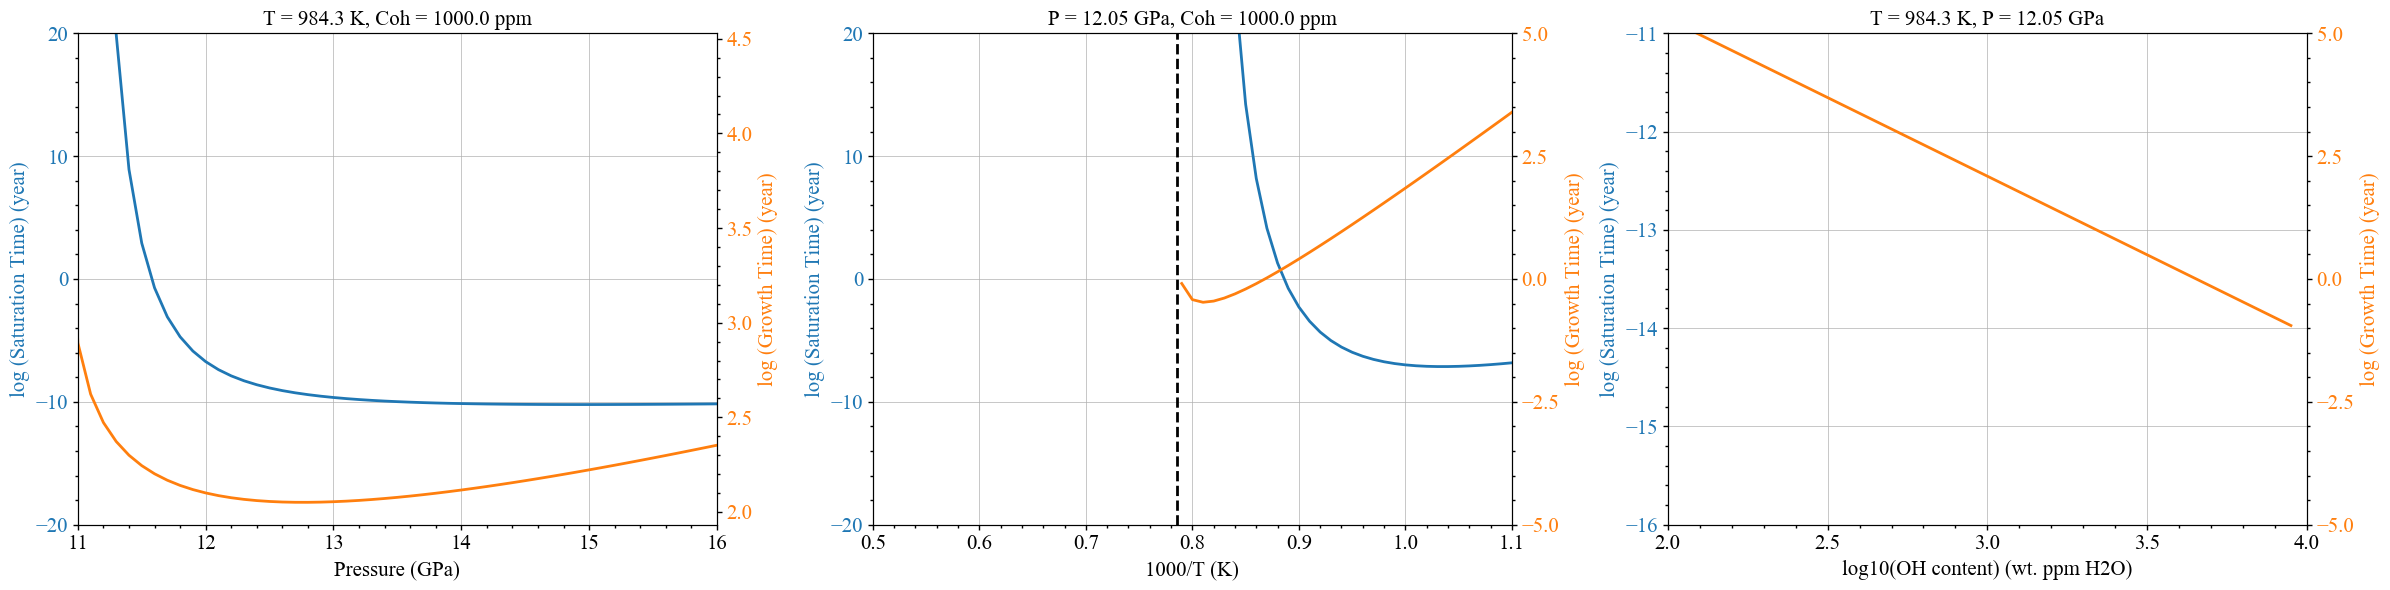

In [15]:
if plot_yoshioka_2015:

    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    
    x_lim = (11.0, 16.0)
    x_lim3 = (0.5, 1.1)
    x_lim5 = (2.0, 4.0)
    y_lim = (-20.0, 20.0)
    y_lim1_1 = (-1.0, 1.0)
    y_lim3 = (-20.0, 20.0)
    y_lim3_1 = (-5.0, 5.0)
    y_lim5 = (-16.0, -11.0)
    y_lim5_1 = (-5.0, 5.0)
    x_tick_interval = 1.0   # tick interval along x
    x_tick_interval3 = 0.1   # tick interval along x
    y_tick_interval = 10.0
    y_tick_interval1_1 = 0.5
    y_tick_interval3 = 10.0
    y_tick_interval3_1 = 2.5
    y_tick_interval5 = 1.0
    y_tick_interval5_1 = 2.5
    
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })


    # initiate figure
    fig, axes = plt.subplots(1, 3, tight_layout=True, figsize=(3*8*scaling_factor, 6*scaling_factor))
    

    # Plot nondimentional time vs Pressure
    ax1 = axes[0] 
    ax1_1 = ax1.twinx()
    sigma_s = calculate_sigma_s(nucleation_rate, growth_rate, d0, kappa=kappa, D=D)
    t_g = d0 / 6.7 / growth_rate

    ax1.plot(Ps / 1e9, np.log10(sigma_s*D*2.0/kappa/year), color=default_colors[0])
    ax1_1.plot(Ps / 1e9, np.log10(t_g/year), color=default_colors[1])
    
    ax1.axvline(x=P_eq / 1e9, color="black", linestyle="--", label=r"$P_{eq}$") # Add a vertical line at P_410

    ax1.grid()

    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    
    # ax1_1.set_ylim(y_lim1_1)
    
    ax1.set_xlabel("Pressure (GPa)")
    ax1.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax1_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])

    ax1.tick_params(axis='y', labelcolor=default_colors[0])
    ax1_1.tick_params(axis='y', labelcolor=default_colors[1])

    ax1.set_title("T = %.1f K, Coh = %.1f ppm" % (T, Coh))
    
    
    # Plot nondimentional time vs Temperature
    
    ax3 = axes[1] 
    ax3_1 = ax3.twinx()

    sigma_s_1 = calculate_sigma_s(nucleation_rate_1, growth_rate_1, d0, kappa=kappa, D=D)
    t_g_1 = d0 / 6.7 / growth_rate_1
    
    ax3.plot(T_invert, np.log10(sigma_s_1*D*2.0/kappa/year), color=default_colors[0])
    ax3_1.plot(T_invert, np.log10(t_g_1/year), color=default_colors[1])
    ax3.axvline(x=1000.0 / T_eq_1, color="black", linestyle="--", label=r"$T_{eq}$") # Add a vertical line at P_410
    
    ax3.set_xlim(x_lim3)
    ax3.set_ylim(y_lim3)
    ax3_1.set_ylim(y_lim3_1)

    ax3.grid()
    
    ax3.set_xlabel("1000/T (K)")
    ax3.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax3_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])
    
    ax3.tick_params(axis='y', labelcolor=default_colors[0])
    ax3_1.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax3.set_title("P = %.2f GPa, Coh = %.1f ppm" % (P/1e9, Coh))

    # Plot nondimentional time vs Coh
    
    ax5 = axes[2] 
    ax5_1 = ax5.twinx()
    
    sigma_s_2 = calculate_sigma_s(nucleation_rate_2, growth_rate_2, d0, kappa=kappa, D=D)
    t_g_2 = d0 / 6.7 / growth_rate_2

    ax5.plot(np.log10(Cohs), np.log10(sigma_s_2*D*2.0/kappa/year), color=default_colors[0])
    ax5_1.plot(np.log10(Cohs), np.log10(t_g_2/year), color=default_colors[1])
    
    ax5.set_xlabel("log10(OH content) (wt. ppm H2O)") 
    ax5.set_ylabel("log (Saturation Time) (year)", color=default_colors[0])
    ax5_1.set_ylabel("log (Growth Time) (year)", color=default_colors[1])
    
    ax5.set_title("T = %.1f K, P = %.2f GPa" % (T, P/1e9))
    
    ax5.set_xlim(x_lim5)
    ax5.set_ylim(y_lim5)
    ax5_1.set_ylim(y_lim5_1)
    
    ax5.tick_params(axis='y', labelcolor=default_colors[0])
    ax5_1.tick_params(axis='y', labelcolor=default_colors[1])
    
    ax5.grid()
    
    # ax3.set_title("P = %.1f GPa, T = %.1f K" % (P / 1e9, T))


    # ax3.semilogy(Ps/1e9, sigma_s)
    # ax3.set_xlabel("Pressure (GPa)")
    # ax3.set_ylabel("Nondimentional Saturation Time")
    # ax3.grid()
    # ax3.set_xlim([13.0, 16.0])
    
    # ax3.axvline(x=P_410 / 1e9, color="black", linestyle="--", label=r"$P_{410}$") # Add a vertical line at P_410

    ax1.xaxis.set_major_locator(MultipleLocator(x_tick_interval)) # set ticks
    ax1.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
    ax1.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
    ax1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))
    
    ax1_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval1_1))
    ax1_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval1_1/(n_minor_ticks+1)))
    
    ax3.xaxis.set_major_locator(MultipleLocator(x_tick_interval3)) # set ticks
    ax3.xaxis.set_minor_locator(MultipleLocator(x_tick_interval3/(n_minor_ticks+1)))
    ax3.yaxis.set_major_locator(MultipleLocator(y_tick_interval3))
    ax3.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3/(n_minor_ticks+1)))
    
    ax3_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval3_1))
    ax3_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval3_1/(n_minor_ticks+1)))
    
    ax5.xaxis.set_major_locator(MultipleLocator(x_tick_interval5)) # set ticks
    ax5.xaxis.set_minor_locator(MultipleLocator(x_tick_interval5/(n_minor_ticks+1)))
    ax5.yaxis.set_major_locator(MultipleLocator(y_tick_interval5))
    ax5.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5/(n_minor_ticks+1)))
    
    ax5_1.yaxis.set_major_locator(MultipleLocator(y_tick_interval5_1))
    ax5_1.yaxis.set_minor_locator(MultipleLocator(y_tick_interval5_1/(n_minor_ticks+1)))


    for spine in ax.spines.values(): 
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)
    
    # save outputs
    file_out = os.path.join(o_dir, "Yoshioka_2015_summary_P_%.1fGPa_T_%.1fK.pdf" % (P/1e9, T))
    fig.savefig(file_out)
    print("Saved figure: %s" % file_out)

    # Reset rcParams to defaults

    rcdefaults()

#### Equation (19): Avrami Number Calculation

The Avrami number, \(Av\), is a dimensionless parameter used to describe the kinetics of phase transformation. It combines slab geometry, thermal diffusivity, and maximum nucleation and growth rates.

##### Key Equation
The Avrami number is defined as:

$$
Av = \left(\frac{D^2}{\kappa}\right)^4 \cdot I_{\text{max}}(P, T) \cdot {Y_{\text{max}}(P, T)}^3
$$

Where:
- $D$: Slab thickness, in $m$.
- $\kappa$: Thermal diffusivity, in $m^2/s$.
- $I_{\text{max}}(P, T)$: Maximum nucleation rate, in $s^{-1} \, m^{-2}$.
- $Y_{\text{max}}(P, T)$: Maximum growth rate, in $m/s$.
- $Av$: Avrami number (dimensionless).

##### Constants and Assumptions
1. **Constants**:
   - $D = 100 \, \text{km} = 1 \times 10^5 \, m$ (fixed slab thickness for this calculation).
   - $\kappa = 1 \times 10^{-6} \, m^2/s$ (typical thermal diffusivity for mantle material).

2. **Assumptions**:
   - $I_{\text{max}}(P, T)$ and $Y_{\text{max}}(P, T)$ are treated as free parameters.
   - The nucleation and growth rates are dependent on experimental or modeled data.
   - The equation assumes uniform geometry and physical properties for the slab.

In [16]:
def calculate_avrami_number_yoshioka_2015(I_max, Y_max, **kwargs):
    """
    Calculate the Avrami number (Av) using the corrected Equation (19).
    
    Parameters:
    - I_max (float): Maximum nucleation rate in s^-1 m^-2.
    - Y_max (float): Maximum growth rate in m/s.
    
    Returns:
    - Av (float): Avrami number (dimensionless).
    """
    kappa = kwargs.get("kappa", 1e-6) # Thermal diffusivity (m^2/s).
    D = kwargs.get("D", 100e3) # slab thickness
    # Compute the Avrami number
    Av = (D**2 / kappa)**4 * I_max * Y_max**3
    return Av

#### Transformed Volume Fraction

The transformed volume fraction, \(V\), is derived as:

$$
V = 1 - \exp\left(-\tilde{V}\right)
$$

where \(\tilde{V}\) represents the **extended volume** per unit volume.

##### Assumptions for Polyhedral Growth

Assuming polyhedral growth (as described in Equation 4 of the Avrami 1941 paper) and that growth rates are consistent across nuclei of different sizes, we have:

##### Growth of the Extended Volume
$$
\frac{d\tilde{V}}{dt} = 4 \pi S Y(t)
$$

where:
- \(S\): Total surface area per unit volume.
- \(Y(t)\): Growth rate as a function of time.

##### Surface Area Evolution
The evolution of the surface area per unit volume is given by:

$$
\frac{dS}{dt} = 2 D_n Y\left(t\right)
$$

where:
- \(D_n\): Total nuclei size per unit volume.

##### Nuclei Size Evolution
The change in total nuclei size per unit volume is:

$$
\frac{dD_n}{dt} = N Y\left(t\right)
$$

where:
- \(N\): Total number of nuclei per unit volume.

##### Nucleation Rate
The change in the number of nuclei per unit volume is governed by:

$$
\frac{dN}{dt} = \frac{6 I(t)}{d_0}
$$

The term of $\frac{6}{d_0}$ roots from the surface area per volume, either by assuming a cubic grain or a spherical grain

where:
- \(I(t)\): Nucleation rate as a function of time.

##### Nondimensionalization

- Time
We nondimensionalize time as:

$$
t = \frac{D^2}{\kappa} \tau
$$

where the term $Av^{\frac{1}{4}}(P, T) \frac{D^2}{\kappa}$ is included to provide an order of magnitude estimate for \(t\), based on the integration required to increase \(X_3\) by one unit at a specific \(P, T\) condition.

- Growth and Nucleation Rates
The growth rate and nucleation rate are nondimensionalized as:

$$
Y(P, T) = Y_{\text{max}}(P, T) Y^{*}(\tau)
$$

Note that $I\left(P, T\right)$ is actually the nucleation rate per unit area (unit: $m^{-2}s^{-1}$)
$$
\frac{6 I(P, T)}{d_0} = I_{\text{max}}(P, T) I^{*}(\tau)
$$
This is the key to reconcile their equations, such that $I_max$ has the sense of nucleated nucleis in unit volume (unit: $m^{-3}s^{-1}$). In this way the definition of Av (eq 19) will be dimentionaless, and their ODEs could be nondimensionalized in the designated way (eq 18).

- Nondimensionalized Properties of Nuclei

The properties of nuclei are nondimensionalized as follows:

1. **Number of Nuclei**:
   $$
   N(t) = Av^{-\frac{1}{4}} I_{\text{max}}(P, T) \frac{D^2}{\kappa} X_0(\tau) = I_{\text{max}}^{\frac{3}{4}} Y_{\text{max}}^{-\frac{3}{4}} X_0
   $$

2. **Total Nuclei Size**:
   $$
   D_n(t) = Av^{-\frac{1}{2}} I_{\text{max}}(P, T) Y_{\text{max}}(P, T) \left(\frac{D^2}{\kappa}\right)^2 X_1(\tau) = I_{\text{max}}^{\frac{1}{2}} Y_{\text{max}}^{-\frac{1}{2}} X_1
   $$

3. **Total Surface Area**:
   $$
   S(t) = Av^{-\frac{3}{4}} I_{\text{max}}(P, T) Y_{\text{max}}^2(P, T) \left(\frac{D^2}{\kappa}\right)^3 X_2(\tau) = = I_{\text{max}}^{\frac{1}{4}} Y_{\text{max}}^{-\frac{1}{4}} X_2
   $$
4. **Extended Volume**:
   $$
   \tilde{V}(t) = \frac{1}{Av} I_{\text{max}}(P, T) Y_{\text{max}}^3(P, T) \left(\frac{D^2}{\kappa}\right)^4 X_3(\tau) = X_3(\tau)
   $$

##### Summary

This nondimensionalization provides a consistent framework for modeling the phase transformation kinetics under varying \(P, T\) conditions. By scaling the time, growth rate, nucleation rate, and nuclei properties, the equations become independent of the absolute magnitude of physical units, facilitating analysis across different systems.


#### Equation (18): system of ODEs

(Delete div to show the correct equation, it just mess up the header list on the OUTLINE block)

<div>
$$
\frac{d}{ds}
\begin{bmatrix}
X_3(s) \\
X_2(s) \\
X_1(s) \\
X_0(s)
\end{bmatrix}
=
Av^{1/4} 
\begin{bmatrix}
0 & 4\pi Y'(s) & 0 & 0 \\
0 & 0 & 2Y'(s) & 0 \\
0 & 0 & 0 & Y'(s) \\
0 & 0 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
X_3(s) \\
X_2(s) \\
X_1(s) \\
X_0(s)
\end{bmatrix}
+
Av^{1/4}
\begin{bmatrix}
0 \\
0 \\
0 \\
I'(s)
\end{bmatrix}
$$
</div>

Where:
- \(X_3(s)\), \(X_2(s)\), \(X_1(s)\), \(X_0(s)\): Represent the total grain volume, total grain area, total grain diameter, and number of grains, respectively.
- \(Av\): Avrami number, defined as $Av = \frac{D^2}{j} \cdot I_{max}(P, T) Y_{max}^3(P, T)$.
- \(Y'(s)\): Dimensionless growth rate.
- \(I'(s)\): Dimensionless nucleation rate.

#### Extended volume after site saturation (eq 20)

$$X_3 = \frac{6.7 D^2}{d_0 \kappa} Y\left(P, T\right) \tau $$

To see why this is consistent with the equations above. Assume the $X_0$ - $X_3$ all start from 0.0 and Y not dependent on $\tau$, do the integration:
$$\tilde{V} = C Y^3 I t^4$$
where C is a constant number of $\frac{8 \pi}{4*3*2} = \frac{\pi}{3}$.
Rewriten this with the nondimentional time $\tau$ would get:
$$\tilde{V} = C Y^3 I \left(\frac{D^2}{\kappa}\right)^4\tau^4$$
Plug in nondimentional saturation time from eq 9 to eq 20, and only apply on the first 3 power of $\tau$:
$$\tilde{V} = C\frac{6.7D^2}{d_0\kappa}Y\left(P, T\right) \tau_s$$
as $\pi / 3$ is very close to 1.0, we see that this is consistent.


#### Note
- I use the name "X_array" for the original array of [$\tilde{V}$, S, D, N], and the name "X_array_nd" for the nondimensionalized array "X_array". This usage is consistent managed in all the code blocks.

In [17]:
# tips: look at class definition in file hamageolib/research/haoyuan_2d_subduction/metastable.py
import research.haoyuan_2d_subduction.metastable as Meta

/home/lochy/ASPECT_PROJECT/HaMaGeoLib/hamageolib/research/haoyuan_2d_subduction/metastable.py:392: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(self.Y_func is not None and self.I_func is not None, self.MO_INITIATION_Error, "Initiation error: call one of the set_kinetics function first.")


#### Set up the MO kinetics

##### Notes

- For slab internal temperture of $500^oC$, the equilibrium pressure is about 10 GPa if Cl is 4 MPa/K. 
- There seems to be a jump in value in $X_3$ when the situation condition is met.

In [18]:
# free parameters
year = 365.0 * 24.0 * 3600.0  # Seconds in one year

# Parameters for equilibrium at the 410 km depth phase boundary
Coh = 1000.0

##### Solve the kinetics at specific P, T condition

In [19]:
# Tips: look at the class definiition in file hamageolib/research/haoyuan_2d_subduction/metastable.py
is_solving_point = True

if is_solving_point:
    # Free parameters, assign values of P, T below
    # P = 14.75e9 # Pa
    # T = 600 + 273.15 # K

    # P = 9.4737e+09

    # A P value (1.1053e10) approaches the equalibrium value will crash the computation
    # P = 1.1053e10  # P_eq ~ 1.09e10
    P = 1.2053e10  # P_eq ~ 1.09e10
    T = 9.8426e+02

    t_max = 10e6 * year # s
    n_t = 100
    n_span = 10

    # initiate the class
    Mo_Kinetics = Meta.MO_KINETICS()
    Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
    Mo_Kinetics.set_kinetics_model(Meta.growth_rate_hosoya_06_eq2, Meta.nucleation_rate_yoshioka_2015)
    Mo_Kinetics.set_kinetics_fixed(P, T, Coh)

    # solve the kinetics
    results = Mo_Kinetics.solve(P, T, t_max, n_t, n_span, debug=True)        

    # csv_file_path = os.path.join(results_dir, "solution_P%.2fGPa_T%.2fK.csv" % (P/1e9, T))
    # results.to_csv(csv_file_path, float_format="%.4e", index=False)
    # print("Solution saved to %s" % csv_file_path)

i_t: 0
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 1
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 2
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 3
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 4
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 5
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 6
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 7
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 8
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 9
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 10
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 11
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 12
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 13
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 14
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av = 1.2564e+39
i_t: 15
I_max = 2.2428e+12, Y_max = 3.8263e-13, Av

Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/MO_kinetics_P12.05GPa_T984.26K.png


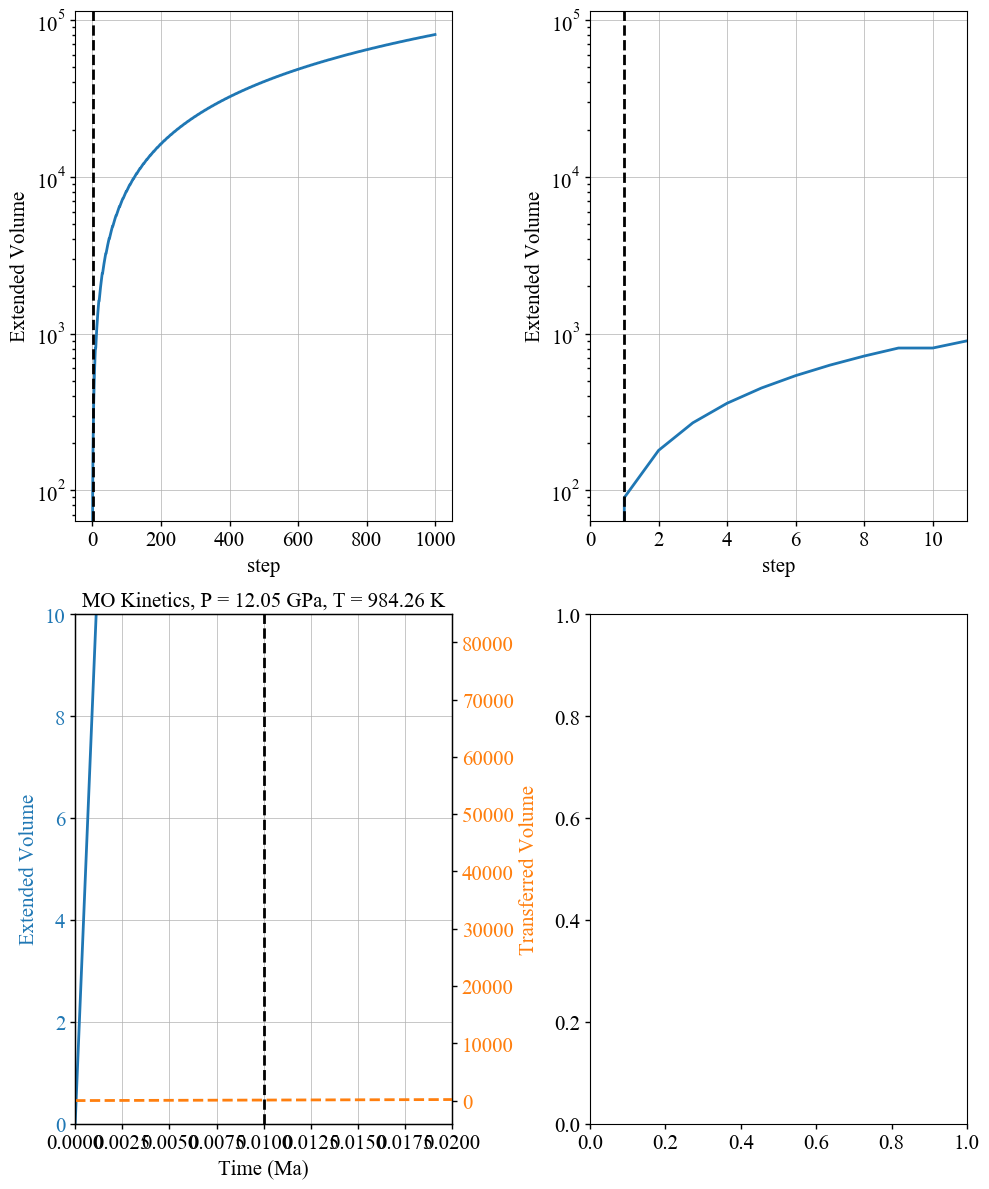

In [20]:
from matplotlib import rcdefaults
from matplotlib.ticker import MultipleLocator

if is_solving_point:

    # Generate a plot for increasing V
    # Retrieve the default color cycle
    default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

    # Example usage
    # Rule of thumbs:
    # 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
    # 2. Set five major ticks for each axis
    scaling_factor = 1.0  # scale factor of plot
    font_scaling_multiplier = 1.5 # extra scaling multiplier for font
    legend_font_scaling_multiplier = 0.5
    line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
    x_lim = (0.0, 10.0)
    x_tick_interval = 2.0   # tick interval along x
    y_lim = (0.0, 100.0)
    y_tick_interval = 20.0  # tick interval along y
    n_minor_ticks = 4  # number of minor ticks between two major ones

    # scale the matplotlib params
    plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                            legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                            line_width_scaling_multiplier=line_width_scaling_multiplier)

    # Update font settings for compatibility with publishing tools like Illustrator.
    plt.rcParams.update({
        'font.family': 'Times New Roman',
        'pdf.fonttype': 42,
        'ps.fonttype': 42
    })

    # get indices of cite saturation
    # indices = np.where(results.is_saturated == True)[0]
    indices = np.where(results[:, 6] == True)[0]

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(2*5*scaling_factor, 2*6*scaling_factor), tight_layout=True)

    # Plot extented volume vs index number
    ax = axs[0, 0]
    ax.semilogy(range(results.shape[0]), results[:, 4], label="Extended Volume", color=default_colors[0])

    if len(indices) > 0:
        ax.axvline(x=indices[0], color='black', linestyle='--')

    ax.set_xlabel("step") # Set x and y labels
    ax.set_ylabel("Extended Volume")

    ax.grid()

    # Plot extented volume vs index number, around cite saturation
    ax = axs[0, 1]
    ax.semilogy(range(results.shape[0]), results[:, 4], label="Extended Volume", color=default_colors[0])

    if len(indices) > 0:
        ax.set_xlim(0, indices[0]+10.0)
        ax.axvline(x=indices[0], color='black', linestyle='--')

    ax.set_xlabel("step") # Set x and y labels
    ax.set_ylabel("Extended Volume")

    ax.grid()

    # Plot extented volume, transfered volume vs time
    ax = axs[1, 0]
    ax1 = ax.twinx()

    ax.plot(results[:, 0] / 1e6 / year, results[:, 4], label="Extended Volume", color=default_colors[0]) # Plot the data
    if len(indices) > 0:
        ax.axvline(x=results[indices[0], 0]/1e6/year, color='black', linestyle='--')
    ax1.plot(results[:, 0] / 1e6 / year, results[:, 4], "--", label="Transferred Volume", color=default_colors[1])

    ax.set_xlabel("Time (Ma)") # Set x and y labels
    ax.set_ylabel("Extended Volume", color=default_colors[0])
    ax1.set_ylabel("Transferred Volume", color=default_colors[1])

    ax.set_xlim(0, 0.02)
    ax.set_ylim(0, 10.0)

    ax.set_title("MO Kinetics, P = %.2f GPa, T = %.2f K" % (P / 1e9, T)) # Set title

    ax.tick_params(axis='y', labelcolor=default_colors[0]) # Match the y-axis colors with the plot colors
    ax1.tick_params(axis='y', labelcolor=default_colors[1])

    ax.grid()

    for spine in ax.spines.values():
        # Adjust spine thickness for this plot
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

    # Save figure
    fig_path = os.path.join(results_dir, "MO_kinetics_P%.2fGPa_T%.2fK.png" % (P / 1e9, T))
    fig.savefig(fig_path)

    print("Saved figure %s" % fig_path)

    # Reset rcParams to defaults
    rcdefaults()

##### Solve the kinetics for a grid

There are two types of process:
* serial: this runs with just one process. It has the advantage of reporting the progress. It could be used to estimate the running speed.
* parallel: this runs in parallel to save time.

In [21]:
import multiprocessing
from joblib import Parallel, delayed
import time

# Free parameters
t_max = 10 * 1e6 * year
n_t = 10
n_span = 20  # finer time steps in a solution

is_solving = False  # if we solve new dataset and merge to old ones

if is_solving:
    ## set resolution of the grid
    # Pressure in Pascals, Temperature in Kelvin, Time in seconds

    P_values = np.linspace(0.0, 30e9, 201)  # global mesh
    T_values = np.linspace(273.15, 1873.15, 101)
    
    # P_values = np.linspace(10e9, 15e9, 51)  # equilibrium bd
    # T_values = np.linspace(773.15, 1873.15, 56)
    
    # P_values = np.linspace(10e9, 30e9, 41)  # metastable bd
    # T_values = np.linspace(750, 1000.0, 51)

    t_values = np.linspace(0, t_max, n_t*n_span)     

    # Create a meshgrid
    T_grid, P_grid, t_grid = np.meshgrid(T_values, P_values, t_values, indexing="ij")
    V_grid = np.zeros(P_grid.shape)

    Mo_Kinetics = Meta.MO_KINETICS()
    Mo_Kinetics.set_PT_eq(PT410['P'], PT410['T'], PT410['cl'])
    Mo_Kinetics.set_kinetics_model(Meta.growth_rate_hosoya_06_eq2, Meta.nucleation_rate_yoshioka_2015)

    # Function to solve for a given T, P
    def solve_metastable_kinetics(P, T, Coh, t_max, n_t, n_span, Mo_Kinetics, P_eq):
        # if P < P_eq:
        #     return np.zeros(n_t * n_span, 7)
        Mo_Kinetics.set_kinetics_fixed(P, T, Coh)
        results = Mo_Kinetics.solve(P, T, t_max, n_t, n_span)
        # Vtilde_clipped = np.clip(results["Vtilde"], None, 709)  # Prevent overflow in exp
        # return 1 - np.exp(-Vtilde_clipped)
        return results

    # Parallelize computation
    start = time.time()

    # Precompute equilibrium pressures
    P_eq_values = [Meta.compute_eq_P(Mo_Kinetics.PT_eq, T) for T in T_values]

    # Solve
    # V_grid = np.zeros(P_grid.shape)
    # for i in range(T_grid.shape[0]):
    #     for j in range(T_grid.shape[1]):
    #         V_array = solve_metastable_kinetics(P_grid[i, j, 0], T_grid[i, j, 0], Coh,t_max, n_t, n_span, Mo_Kinetics, P_eq_values[i])
    #         V_grid[i, j, :] = V_array
    #         sys.stdout.write("\rsolved %d / %d" % (i*T_grid.shape[1]+j, T_grid.shape[0]*T_grid.shape[1]-1)) # debug
    #         sys.stdout.flush()
    # sys.stdout.write("\nSolve Metastable Kinetics take %.2f s" % (end-start))
    # sys.stdout.flush()

    # Solve in parallel
    num_processes = multiprocessing.cpu_count()  # Print the number of available processes
    print(f"Number of available processes: {num_processes}")

    results_raw = Parallel(n_jobs=-1)(
        delayed(solve_metastable_kinetics)(
            P_grid[i, j, 0], T_grid[i, j, 0], Coh,t_max, n_t, n_span, Mo_Kinetics, P_eq_values[i]
        )
        for i in range(T_grid.shape[0]) for j in range(T_grid.shape[1])
    )

    # Convert results_raw to a structured grid
    grid_shape = (T_grid.shape[0], T_grid.shape[1])  # Grid size
    time_steps = results_raw[0].shape[0]  # Number of time steps
    num_columns = results_raw[0].shape[1]  # Number of variables

    results_array = np.array(results_raw)  # Convert list to NumPy array
    results_grid = results_array.reshape(*grid_shape, time_steps, num_columns)  # Reshape to grid

    # Access specific data
    V_grid = results_grid[:, :, :, 5]  # Extract column 0 across all grid points

    end = time.time()
    print("\nSolve Metastable Kinetics took %.2f s" % (end - start))

Number of available processes: 12

Solve Metastable Kinetics took 3.41 s


In [22]:
# Convert to numpy object
data_raw = []

for i in range(T_grid.shape[0]):
    for j in range(T_grid.shape[1]):
        # Extract the pressure and temperature for this grid point
        P_value = P_grid[i, j, 0]
        T_value = T_grid[i, j, 0]
        
        # Extract the corresponding results
        result = results_raw[i * T_grid.shape[1] + j]  # Flattened indexing
        
        # Combine P, T with each row of the results
        for k in range(result.shape[0]):  # Iterate over time steps
            row = [P_value, T_value] + result[k].tolist()  # Combine P, T, and the result row
            data_raw.append(row)

data_array = np.array(data_raw) # Convert the list of rows into a 2D NumPy array

# Convert to pandas object
columns = ["P", "T"] + Mo_Kinetics.result_columns

new_data = pd.DataFrame(data_array, columns=columns)

In [23]:
from datetime import datetime
from shutil import copy

# working directory and file
current_results_dir = os.path.join(results_dir, "grid_data_01072025")
if not os.path.isdir(current_results_dir):
    os.mkdir(current_results_dir)

data_file = os.path.join(current_results_dir, "metastable_grid_data.parquet")
data_file_csv = os.path.join(current_results_dir, "metastable_grid_data.csv")

if os.path.isfile(data_file):
    # generate a backup
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    data_file_backup = os.path.join(current_results_dir, f"metastable_grid_data_{timestamp}.parquet")

    copy(data_file, data_file_backup)

    print("created backup file %s" % data_file_backup)
    
    # 
    data = pd.read_parquet(data_file)

    if is_solving:

        # Identify existing combinations of P and T in data
        existing_combinations = set(zip(data["P"], data["T"]))

        # Filter new_data to exclude rows with existing P and T combinations
        filtered_new_data = new_data[~new_data.apply(lambda row: (row["P"], row["T"]) in existing_combinations, axis=1)]

        # Merge the filtered new_data into data
        data = pd.concat([data, filtered_new_data], ignore_index=True)

else:
    data = new_data
        
# Save data
data.to_parquet(data_file, index=False)
data.to_csv(data_file_csv, index=False)

print("saved parquet file %s" % data_file)
print("saved csv file %s" % data_file_csv)

saved parquet file /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/grid_data_01072025/metastable_grid_data.parquet
saved csv file /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/grid_data_01072025/metastable_grid_data.csv


##### Plot the diagram

With the interpolation scheme, we define both a near-neighbor interpolation and a inverse distance weighting (IDW) interpolation

First, we create a new grid to plot.

In [24]:
from scipy.interpolate import NearestNDInterpolator

## for a global mesh
P_values_1 = np.linspace(0.0, 30e9, 200)  # Pressure in Pascals
T_values_1 = np.linspace(273.15, 1873.15, 100)  # Temperature in Kelvin

# scaling factors
P0 = 1e9 # Pa
T0 = 100.0 # K
t0 = 10000 * year # s

# make a new grid
T_grid_1, P_grid_1 = np.meshgrid(T_values_1, P_values_1)

T_flat_1 = T_grid_1.flatten()
P_flat_1 = P_grid_1.flatten()

# compute equilibrium values
P_eq_values_1 = Meta.compute_eq_P(Mo_Kinetics.PT_eq, T_values_1)

# perform interpolation
interpolator = NearestNDInterpolator(
    np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)),
    data["V"]
)

Then, we plot at a given time

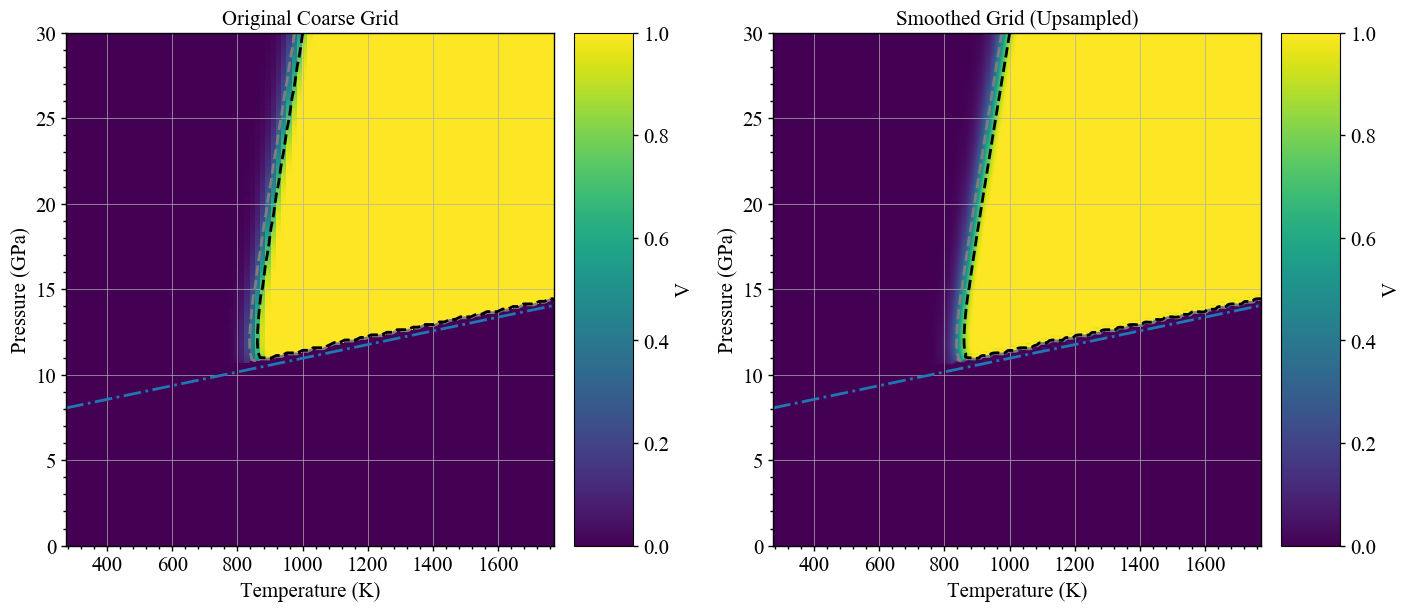

Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/PTV_t0.05.png


In [25]:
from scipy.ndimage import zoom

# Rule of thumbs:
# 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
# 2. Set five major ticks for each axis
scaling_factor = 1.0  # scale factor of plot
font_scaling_multiplier = 1.5 # extra scaling multiplier for font
legend_font_scaling_multiplier = 0.5
line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
x_lim = (273.15, 1773.15)
x_tick_interval = 200.0   # tick interval along x
y_lim = (0.0, 30.0)
y_tick_interval = 5.0  # tick interval along y
n_minor_ticks = 4  # number of minor ticks between two major ones

# scale the matplotlib params
plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                        line_width_scaling_multiplier=line_width_scaling_multiplier)

# Update font settings for compatibility with publishing tools like Illustrator.
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# constant time
t_constant = 5e4*year     # Time in seconds

# perform interpolation 1: near neighber
V_flat_1 = interpolator(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, t_constant/t0))

# # perform interpolation 2: IDW
# V_flat = idw_interpolation(np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)), data["V"],\
#                             np.column_stack((T_flat / T0, P_flat / P0, np.full(T_flat.shape, t_constant / t0))), k=5, power=2)

# reshape to V_grid
V_grid = V_flat_1.reshape(T_grid_1.shape)

# Upsample the V_grid for smoothing
# Define finer grid based on zoom factor
zoom_factor = 5  # Upscaling factor
V_smooth_grid = zoom(V_grid, zoom_factor, order=3)  # Cubic spline interpolation

T_fine = np.linspace(np.min(T_values_1), np.max(T_values_1), V_smooth_grid.shape[1])
P_fine = np.linspace(np.min(P_values_1), np.max(P_values_1), V_smooth_grid.shape[0])
T_fine_grid, P_fine_grid = np.meshgrid(T_fine, P_fine)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot original coarse grid
h1 = axes[0].pcolormesh(T_grid_1, P_grid_1 / 1e9, V_grid, cmap="viridis", shading="auto")
axes[0].contour(T_grid_1, P_grid_1 / 1e9, V_grid, (0.4, 0.8), colors=['tab:gray', 'k'], linestyles="--")
axes[0].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

axes[0].grid()

axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)

axes[0].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
axes[0].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
axes[0].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
axes[0].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

axes[0].set_xlabel("Temperature (K)")
axes[0].set_ylabel("Pressure (GPa)")
axes[0].set_title("Original Coarse Grid")
fig.colorbar(h1, ax=axes[0], label="V")

# Plot smoothed grid
h2 = axes[1].pcolormesh(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, cmap="viridis", shading="auto", vmin=0.0, vmax=1.0)
axes[1].contour(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, (0.4, 0.8), colors=['tab:gray', 'k'], linestyles="--")
axes[1].plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

axes[1].grid()

axes[1].set_xlim(x_lim)
axes[1].set_ylim(y_lim)

axes[1].xaxis.set_major_locator(MultipleLocator(x_tick_interval))
axes[1].xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
axes[1].yaxis.set_major_locator(MultipleLocator(y_tick_interval))
axes[1].yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

axes[1].set_xlabel("Temperature (K)")
axes[1].set_ylabel("Pressure (GPa)")
axes[1].set_title("Smoothed Grid (Upsampled)")
fig.colorbar(h2, ax=axes[1], label="V")

# Adjust spine thickness for this plot
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

plt.show()

# save figure
fig_path = os.path.join(results_dir, "PTV_t%.2f.png" % (t_constant/1e6/year))
fig.savefig(fig_path)

print("Saved figure %s" % fig_path)

# fig_path_pdf = os.path.join(results_dir, "PTV_t%.2f.pdf" % (t_constant/1e6/year))
# fig.savefig(fig_path_pdf)

# print("Saved figure %s" % fig_path_pdf)


# Reset rcParams to defaults

rcdefaults()

Then we handle plots of contours at different time step

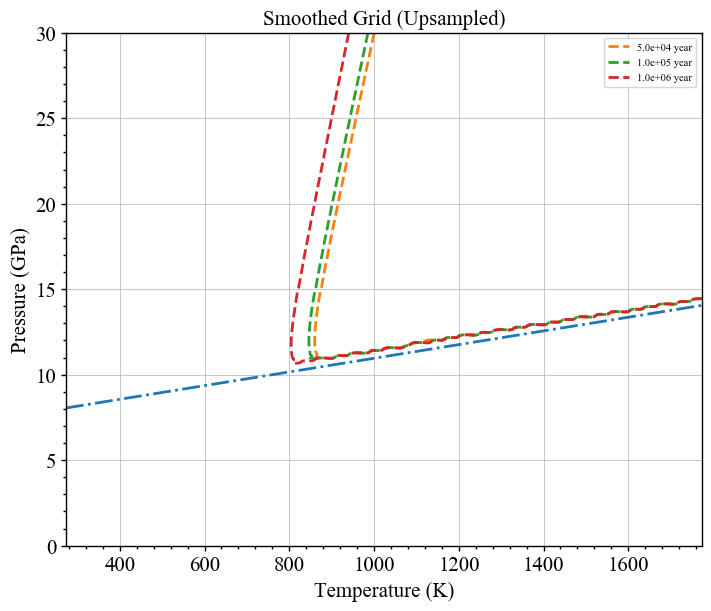

Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/PTV_contours.png
Saved figure /home/lochy/ASPECT_PROJECT/HaMaGeoLib/dtemp/PTV_contours.pdf


In [26]:
from scipy.ndimage import zoom
from matplotlib.lines import Line2D

# Retrieve the default color cycle
default_colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

# Rule of thumbs:
# 1. Set the limit to something like 5.0, 10.0 or 50.0, 100.0 
# 2. Set five major ticks for each axis
scaling_factor = 1.0  # scale factor of plot
font_scaling_multiplier = 1.5 # extra scaling multiplier for font
legend_font_scaling_multiplier = 0.5
line_width_scaling_multiplier = 2.0 # extra scaling multiplier for lines
x_lim = (273.15, 1773.15)
x_tick_interval = 200.0   # tick interval along x
y_lim = (0.0, 30.0)
y_tick_interval = 5.0  # tick interval along y
n_minor_ticks = 4  # number of minor ticks between two major ones

# scale the matplotlib params
plot_helper.scale_matplotlib_params(scaling_factor, font_scaling_multiplier=font_scaling_multiplier,\
                        legend_font_scaling_multiplier=legend_font_scaling_multiplier,
                        line_width_scaling_multiplier=line_width_scaling_multiplier)

# Update font settings for compatibility with publishing tools like Illustrator.
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})


# constant time
ts = np.array([5e4, 1e5, 1e6]) * year

# Create subplots
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

ax.plot(T_values_1, P_eq_values_1/1e9, "-.")  # plot the equilibrium phase boundary

# Initialize a list for legend entries
legend_lines = []
legend_labels = []

for i, t_constant in enumerate(ts):

    # perform interpolation 1: near neighber
    V_flat_1 = interpolator(T_flat_1/T0, P_flat_1/P0, np.full(T_flat_1.shape, t_constant/t0))

    # # perform interpolation 2: IDW
    # V_flat = idw_interpolation(np.column_stack((data["T"]/T0, data["P"]/P0, data["t"]/t0)), data["V"],\
    #                             np.column_stack((T_flat / T0, P_flat / P0, np.full(T_flat.shape, t_constant / t0))), k=5, power=2)

    # reshape to V_grid
    V_grid = V_flat_1.reshape(T_grid_1.shape)

    # Upsample the V_grid for smoothing
    # Define finer grid based on zoom factor
    zoom_factor = 5  # Upscaling factor
    V_smooth_grid = zoom(V_grid, zoom_factor, order=3)  # Cubic spline interpolation

    T_fine = np.linspace(np.min(T_values_1), np.max(T_values_1), V_smooth_grid.shape[1])
    P_fine = np.linspace(np.min(P_values_1), np.max(P_values_1), V_smooth_grid.shape[0])
    T_fine_grid, P_fine_grid = np.meshgrid(T_fine, P_fine)

    # Plot smoothed grid
    contour = ax.contour(T_fine_grid, P_fine_grid / 1e9, V_smooth_grid, [0.8], colors=[default_colors[i+1]], linestyles="--")

    # Add entry to legend list
    legend_lines.append(Line2D([0], [0], color=default_colors[i+1], linestyle="--"))
    legend_labels.append("%.1e year" % (t_constant/year))

ax.legend(legend_lines, legend_labels)

ax.grid()

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(MultipleLocator(x_tick_interval))
ax.xaxis.set_minor_locator(MultipleLocator(x_tick_interval/(n_minor_ticks+1)))
ax.yaxis.set_major_locator(MultipleLocator(y_tick_interval))
ax.yaxis.set_minor_locator(MultipleLocator(y_tick_interval/(n_minor_ticks+1)))

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")
ax.set_title("Smoothed Grid (Upsampled)")


# Adjust spine thickness for this plot
for spine in ax.spines.values():
    spine.set_linewidth(0.5 * scaling_factor * line_width_scaling_multiplier)

plt.show()

# save figure
fig_path = os.path.join(results_dir, "PTV_contours.png")
fig.savefig(fig_path)

print("Saved figure %s" % fig_path)

fig_path_pdf = os.path.join(results_dir, "PTV_contours.pdf")
fig.savefig(fig_path_pdf)

print("Saved figure %s" % fig_path_pdf)

# Reset rcParams to defaults

rcdefaults()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

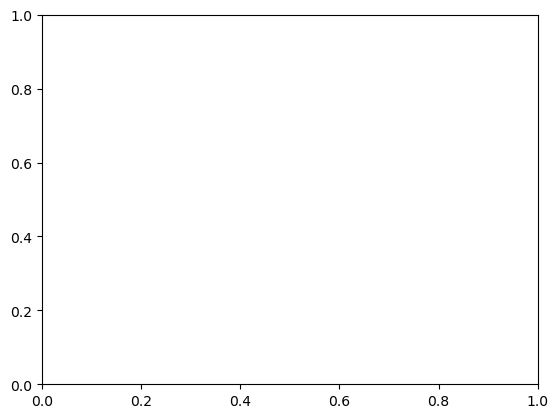

In [27]:
# from mpl_toolkits.mplot3d import Axes3D

time_index = n_t*n_span - 1

# fig = plt.figure()
# ax = fig.add_subplot(111) # , projection='3d')
fig, ax = plt.subplots()

# surf = ax.plot_trisurf(P_flat, T_flat, V_flat, cmap="viridis")
# fig.colorbar(surf, label="V")
# ax.set_zlabel("V")

h = ax.pcolormesh(T_grid[:, :, time_index], P_grid[:, :, time_index] / 1e9, V_grid[:, :, time_index], cmap="viridis")

# ax.plot(T_eq_values, P_eq_values/1e9, "--")

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Pressure (GPa)")

ax.set_xlim([np.min(T_values), np.max(T_values)])
ax.set_ylim([np.min(P_values)/1e9, np.max(P_values)/1e9])

fig.colorbar(h, ax=ax, label="V")

plt.title(f"3D Surface of V(P, T) at t = {t_values[time_index]/1e6/year:.2f} Ma")
plt.show()

fig_path = os.path.join(results_dir, "PTV_t%.2f_nt%d_nspan%d.png" % (t_max/1e6/year, n_t, n_span))
fig.savefig(fig_path)

print("Saved figure %s" % fig_path)

### Run test cases

These blocks follow these steps:
* Run a test case
* Export the dataset from the pvtu files
* Apply a nearneighbor interpolation
* Plot the colormap and the contours

#### Run aspect

##### Key Steps
- **Input Verification**:
  - Ensures the provided `case_dir` directory exists.
  - Validates the presence of the parameter file (`case.prm`) required for the ASPECT run.

- **Execution**:
  - Runs the ASPECT executable using `subprocess.run`.
  - Captures both `stdout` (standard output) and `stderr` (standard error) for validation.

- **Output Validation**:
  - Verifies that the expected wallclock time summary appears in the output log.
  - Ensures that the error stream (`stderr`) is empty, confirming a successful execution.

In [ ]:
import subprocess
import re
import os
import json
from shutil import copy
from utils.dealii_param_parser import parse_parameters_to_dict, save_parameters_from_dict
from utils.world_builder_file_parser import find_feature_by_name, update_or_add_feature

# Define paths to the ASPECT executable and the case directory
aspect_executable = "/home/lochy/Softwares/aspect/build_master_TwoD/aspect"
group_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/MO_kinetics_test"
template_dir = os.path.join(group_dir, "test_case_template")  # Directory containing templates
# case_dir = "/mnt/lochz/ASPECT_DATA/TwoDSubduction/MO_kinetics_test/test_case_ini"  # Initial case, larger geometry

# Ensure the case directory exists
assert(os.path.isdir(template_dir))

prm_template_path = os.path.join(template_dir, "case.prm")
assert(os.path.isfile(prm_template_path))

wb_template_path = os.path.join(template_dir, "case.wb")
assert(os.path.isfile(wb_template_path))

# Case setups
wb_sp_velocity = 0.08 # m/yr
wb_sp_age = 140e6 # yr
wb_trench_x = 200e3 # m
wb_ridge_x = wb_trench_x - wb_sp_age * wb_sp_velocity

case_dir = os.path.join(group_dir, "test_case_sp%.1f_v%.1e" % (wb_sp_age/1e6, wb_sp_velocity*100))  # Directory containing templates
if not os.path.isdir(case_dir):
    os.mkdir(case_dir)

# Modify the template

with open(prm_template_path, 'r') as file:
    params_dict = parse_parameters_to_dict(file)

params_dict["Output directory"] = os.path.join(case_dir, "output")
params_dict["World builder file"] = os.path.join(case_dir, "case.wb")

with open(wb_template_path, 'r') as fin:
    wb_dict = json.load(fin)
    
slab_dict = find_feature_by_name(wb_dict, "Slab") # Extract the "Slab" feature from the World Builder data
sp_dict = find_feature_by_name(wb_dict, "Subducting plate")

slab_dict["coordinates"] = [[wb_trench_x, -1000.0], [wb_trench_x, 1000.0]]
slab_dict["temperature models"][0]["plate velocity"] = wb_sp_velocity
slab_dict["temperature models"][0]["ridge coordinates"][0] = [[wb_ridge_x , 1000.0], [wb_ridge_x , 1000.0]]

sp_dict["temperature models"][0]["plate age"] = wb_sp_age 

wb_dict = update_or_add_feature(wb_dict, "Slab", slab_dict)
wb_dict = update_or_add_feature(wb_dict, "Subducting plate", sp_dict)

# Define paths to the parameter file and world builder file within the case directory

prm_path = os.path.join(case_dir, "case.prm")
wb_path = os.path.join(case_dir, "case.wb")

with open(prm_path, 'w') as output_file:
    save_parameters_from_dict(output_file, params_dict)

with open(wb_path, 'w') as fout:
    json.dump(wb_dict, fout)

# Ensure the parameter file exists
assert(os.path.isfile(prm_path))
assert(os.path.isfile(wb_path))

# Run the ASPECT executable with the parameter file
# The function ensures that both the expected outputs are generated and no errors are produced
# 'capture_output=True' collects both stdout and stderr for further checks
completed_process = subprocess.run([aspect_executable, prm_path], capture_output=True, text=True)

# Capture the standard output and error streams
stdout = completed_process.stdout
stderr = completed_process.stderr

# Uncomment the following lines for debugging purposes to inspect the output
# print(stdout)  # Debugging: Prints the standard output
# print(stderr)  # Debugging: Prints the standard error

# Check if the expected line indicating wallclock time appears in the output
# The expected line format is something like:
# -- Total wallclock time elapsed including restarts: 1s
assert(re.match(".*Total wallclock", stdout.split('\n')[-6]))

# Ensure that the error stream is empty, indicating no issues during the run
assert(stderr == "")

#### Export data and plot

This script reads simulation data from a `.pvtu` file, processes it using VTK and NumPy, and sets up interpolators for various physical fields such as temperature, pressure, and resolution.

##### Key Steps
- **Data Loading**:
  - Reads an unstructured grid from a `.pvtu` file using `vtkXMLPUnstructuredGridReader`.
  - Extracts point coordinates, cell connectivity, and point-wise data (e.g., temperature and pressure).

- **Resolution Calculation**:
  - A custom function (`calculate_resolution`) computes resolution metrics for the grid.

- **vtkPolyData Construction**:
  - Creates a `vtkPolyData` object to hold point and cell information.
  - Adds scalar and field data (temperature and pressure) to the `vtkPolyData` object.

- **Data Export to NumPy**:
  - Converts VTK point and field data to NumPy arrays for further processing.

- **Interpolator Creation**:
  - Constructs nearest-neighbor interpolators for temperature, pressure, and resolution using `NearestNDInterpolator`.


In [ ]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
from utils.vtk_utilities import calculate_resolution
import time
import numpy as np
from scipy.interpolate import NearestNDInterpolator

# Define the input file path and field names to extract
pvtu_file = os.path.join(case_dir, "output", "solution", "solution-00005.pvtu")
field_names = ["T", "p"]  # Field names to extract: temperature (T) and pressure (p)

# Read the pvtu file
reader = vtk.vtkXMLPUnstructuredGridReader()
reader.SetFileName(pvtu_file)
reader.Update()

start = time.time()

# Get the output data from the reader
grid = reader.GetOutput()  # Access the unstructured grid
data_set = reader.GetOutputAsDataSet()  # Access the dataset representation
points = grid.GetPoints()  # Extract the points (coordinates)
cells = grid.GetCells()  # Extract the cell connectivity information
point_data = data_set.GetPointData()  # Access point-wise data

end = time.time()
print("Reading files takes %.2f s" % (end - start))
start = end

# Calculate resolution for each cell or point in the grid
resolutions = calculate_resolution(grid)  # Custom function (not defined here)

end = time.time()
print("Calculating resolution takes %.2f s" % (end - start))
start = end

# Construct a vtkPolyData object to hold points and cell information
i_poly_data = vtk.vtkPolyData()
i_poly_data.SetPoints(points)  # Add points to the PolyData object
i_poly_data.SetPolys(cells)  # Add cell connectivity to the PolyData object

# Add point data fields to the vtkPolyData
for idx, field_name in enumerate(field_names):
    array = point_data.GetArray(field_name)  # Retrieve the field array
    if array:
        if idx == 0:  # The first field becomes Scalars
            i_poly_data.GetPointData().SetScalars(array)
        else:  # Additional fields are added as arrays
            i_poly_data.GetPointData().AddArray(array)
    else:
        print(f"Warning: Field {field_name} not found.")  # Warn if field is missing

# Validate that points were successfully added to the vtkPolyData object
noP = i_poly_data.GetNumberOfPoints()
if noP == 0:
    raise ValueError("No points were added to i_poly_data!")

end = time.time()
print("Constructing polydata takes %.2f s" % (end - start))
start = end

# Export data to NumPy arrays for easier processing
points_np = vtk_to_numpy(i_poly_data.GetPoints().GetData())  # Convert points to NumPy
Ts = vtk_to_numpy(i_poly_data.GetPointData().GetArray("T"))  # Temperature array
Ps = vtk_to_numpy(i_poly_data.GetPointData().GetArray("p"))  # Pressure array

end = time.time()
print("Exporting data to NumPy arrays takes %.2f s" % (end - start))

# Extract 2D coordinates (x, y) from the points
points_2d = points_np[:, :2]  # Use only the first two columns for 2D coordinates

# Create interpolators for temperature, pressure, and resolution
interpolator = NearestNDInterpolator(points_2d, Ts)  # Interpolator for temperature
interpolator_P = NearestNDInterpolator(points_2d, Ps)  # Interpolator for pressure
interpolator_r = NearestNDInterpolator(points_2d, resolutions)  # Interpolator for resolution

#### Interpolate to a regular grid

This script interpolates simulation data (e.g., temperature, resolution) onto a regular 2D grid and visualizes it using various plots, including colormaps and contour plots.

##### Key Steps
1. **Grid Creation**:
   - Defines a regular grid with a specified interval (10 km).
   - Determines grid bounds from the original data.

2. **Data Interpolation**:
   - Interpolates temperature ($T$) and resolution values onto the regular grid using `NearestNDInterpolator`.

3. **Visualization**:
   - Creates three subplots:
     - Temperature colormap with overlaid contours.
     - Resolution colormap.
     - Slab internal region masked by temperature thresholds.

4. **Output**:
   - Displays the plots.
   - Saves the temperature plot to a PDF file in the case directory.

##### Constants and Assumptions
- **Grid Interval**:
  - $\text{Interval} = 10^4 \, \text{m}$ (10 km).
- **Temperature Mask**:
  - Slab region is defined as $T < 1173.15 \, \text{K}$ (900°C).

##### Output
- **Plots**:
  - Temperature colormap with contours ($T$ in $K$).
  - Resolution colormap.
  - Slab internal region.

- **Saved File**:
  - Temperature plot saved as `T.pdf`.


In [ ]:
# Interpolate to regular grid
# Assuming `points` is an (n, 3) array of (x, y, z) coordinates
# and `Ts` is a (n,) array with corresponding T values

import numpy as np
from scipy.interpolate import NearestNDInterpolator

# Define the interval for the grid (in meters)
interval = 5e3  # 10 km grid interval

# Determine the bounding box of the 2D points
x_min, y_min = np.min(points_2d, axis=0)
x_max, y_max = np.max(points_2d, axis=0)

# Define a regular grid within the bounding box
x_grid = np.arange(x_min, x_max, interval)
y_grid = np.arange(y_min, y_max, interval)
xv, yv = np.meshgrid(x_grid, y_grid, indexing="ij")  # Create a grid of (x, y) points

# Flatten the grid for interpolation
grid_points_2d = np.vstack([xv.ravel(), yv.ravel()]).T

# Interpolate temperature (T) values onto the regular grid
T_grid = interpolator(grid_points_2d)  # Use the NearestNDInterpolator
T_grid = T_grid.reshape(xv.shape)  # Reshape back to the grid

# Interpolate temperature (P) values onto the regular grid
P_grid = interpolator_P(grid_points_2d)  # Use the NearestNDInterpolator
P_grid = P_grid.reshape(xv.shape)  # Reshape back to the grid

# Interpolate resolutions onto the regular grid
resolutions_grid = interpolator_r(grid_points_2d)
resolutions_grid = resolutions_grid.reshape(xv.shape)

end = time.time()
print("Interpolating to regular grid takes %.2f s" % (end - start))
start = end

# Initialize plots
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Create a figure with a 2x2 grid layout
fig = plt.figure(figsize=(12, 10), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

# Plot a colormap of T with contour
ax = fig.add_subplot(gs[0, 0])
color_map = ax.contourf(xv, yv, T_grid, levels=100, cmap="viridis")  # Interpolated T colormap
cbar = fig.colorbar(color_map, ax=ax, label="Interpolated T")  # Add colorbar
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Add contour lines to the colormap
contours = ax.contour(
    xv, yv, T_grid, levels=np.arange(373.15, 1673.15 + 100.0, 200.0), colors="black", linewidths=0.5
)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.1f")  # Add labels to the contours
ax.set_aspect("equal", adjustable="box")  # Equal aspect ratio

# Plot a resolution of meshes
ax1 = fig.add_subplot(gs[0, 1])
color_map1 = ax1.contourf(xv, yv, resolutions_grid, levels=100, cmap="plasma_r")  # Resolution colormap
cbar1 = fig.colorbar(color_map1, ax=ax1, label="Resolution")  # Add colorbar
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_aspect("equal", adjustable="box")  # Equal aspect ratio

# Plot the slab internal region
ax2 = fig.add_subplot(gs[1, 0])
mask_slab = T_grid < 1173.15  # Mask for temperatures below 900°C
slab_grid = np.zeros(xv.shape, dtype=bool)  # Initialize slab grid
slab_grid[mask_slab] = 1.0  # Set mask condition
color_map2 = ax2.pcolormesh(xv, yv, slab_grid, cmap="gray", shading="auto")  # Plot slab internal region

try:
    cbar2 = fig.colorbar(color_map2, ax=ax2, label="Slab internal")  # Add colorbar if possible
except Exception:
    pass

# Show figure
plt.show()

# Save figure to a PDF file
pdf_path = os.path.join(case_dir, "T.pdf")
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

end = time.time()
print("Plotting color map takes %.2f s" % (end - start))
start = end

#### Analytic computation of the kinetics

##### Key Steps

Load World Builder Data:

Reads the slab definition from a JSON file.
Extracts slab segments, trench location, and subduction velocity.
Segment Analysis:

Computes segment lengths, depths, and dip angles.
Determines distances to the slab curve for visualization purposes.
Visualization:

Plots lengths and dip angles against depth using twin y-axes.
Adds legends, gridlines, and labels for clarity.
Output:

Saves the plot as a PDF file.

In [ ]:
import json

# Define constants
year = 365 * 24 * 3600.0  # Number of seconds in a year

# Load the World Builder (wb) file
assert(os.path.isfile(wb_path))  # Ensure the file exists
with open(wb_path, 'r') as fin:
    wb_dict = json.load(fin)  # Load JSON content into a dictionary

# Extract the "Slab" feature from the World Builder data
slab_dict = find_feature_by_name(wb_dict, "Slab")

# Extract slab properties from the loaded data
slab_segments = slab_dict["segments"]  # Retrieve slab segment definitions
trench_x = slab_dict["coordinates"][0][0]  # Extract trench x-coordinate
subduct_velocity = slab_dict["temperature models"][0]["plate velocity"] / year  # Convert velocity to m/s

# Process the slab segments to compute relevant properties
lengths, depths, dip_angles, Xs = process_segments(slab_segments, n_spacing=100)  # Segment analysis

# Calculate subduction times
sub_ts = lengths / subduct_velocity

# Compute distances to the slab curve
distance_v = distances_to_curve(Xs + trench_x, y_max - depths, xv.ravel(), yv.ravel())
distance_grid = distance_v.reshape(xv.shape)  # Reshape distances to grid shape

# Initialize figure for plotting lengths and dip angles vs. depths
fig = plt.figure(figsize=(8, 6), tight_layout=True)
gs = gridspec.GridSpec(1, 1)

# Create the first subplot for lengths
ax1 = fig.add_subplot(gs[0, 0])
color1 = 'tab:blue'
ax1.plot(depths, lengths, label="Lengths", color=color1, linewidth=2)  # Plot lengths
ax1.set_xlabel("Depth (m)")
ax1.set_ylabel("Lengths (m)", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a twin y-axis for dip angles
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.plot(depths, dip_angles, label="Dip Angles", color=color2, linestyle="--", linewidth=2)  # Plot dip angles
ax2.set_ylabel("Dip Angles (°)", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Add legends and customize the plot
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_title("Lengths and Dip Angles vs Depths")
ax1.grid(True, linestyle="--", alpha=0.5)

# Save the figure as a PDF
pdf_path = os.path.join(case_dir, "slab_curve.pdf")
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

# Display the figure
plt.show()


#### Derive a subduction time

##### Key Steps
1. **Depth Grid Calculation**:
   - Converts $y$-coordinates to depths ($\text{depth}_{\text{grid}} = y_{\text{max}} - y_v$).
   - Interpolates segment lengths along the depth grid.

2. **Slab Internal Masking**:
   - Defines the slab's internal region based on distances from the slab surface (-5 km to 100 km).

3. **Subduction Time Calculation**:
   - Computes subduction time ($t_{\text{sub}}$) for points inside the slab using:
     $$ t_{\text{sub}} = \frac{\text{length}}{\text{subduction velocity}} $$

4. **Contour Generation**:
   - Generates contours at specified distances (e.g., 5 km) from the slab surface.

##### Constants and Assumptions
- **Slab Internal Mask**:
  - Distance range for slab internals: $-5 \, \text{km} \leq \text{distance} \leq 100 \, \text{km}$.
- **Contour Distance**:
  - A single contour at $5 \, \text{km}$ from the slab surface.

In [ ]:
# Derive the slab internal points, create contours on distance to the slab surface
# and plot subduction time (`t_sub`) along profiles

# Compute the depth grid
depth_grid = y_max - yv  # Convert y-coordinates to depths
depth_grid_flat = depth_grid.ravel()  # Flatten depth grid for interpolation

# Interpolate length values along the depth grid
length_grid_flat = np.interp(depth_grid_flat, depths, lengths)  # Interpolate lengths at depth values
length_grid = length_grid_flat.reshape(depth_grid.shape)  # Reshape back to grid format

# Create a mask for slab internals based on distance to the slab surface
mask_slab1 = (distance_grid >= -5e3) & (distance_grid <= 100e3)  # Slab internal region: -5 km to 100 km

# Compute subduction time (`t_sub`) for points inside the slab
t_sub_grid = np.full(xv.shape, float("inf"))  # Initialize with infinity for points outside the slab
t_sub_grid[mask_slab1] = length_grid[mask_slab1] / subduct_velocity  # Compute `t_sub` where the mask applies


We follow by plotting the slab surface. Meanwhile, we check the value of subducting time from the trench.

In [ ]:
# Plot distance to slab surface
fig = plt.figure(figsize=(8, 12), tight_layout=True)
gs = gridspec.GridSpec(2, 1)

ax3 = fig.add_subplot(gs[0, 0])

color_map3 = ax3.contourf(xv, yv, distance_grid/1e3, levels=100, cmap="cividis")
cbar3 = fig.colorbar(color_map3, ax=ax3, label="Distance to surface (km)")

ax3.plot(Xs + trench_x, y_max - depths, ".") # slab surface

ax3.set_xlim([0.0, x_max])
ax3.set_ylim([0.0, y_max])

ax3.set_xlabel("X")
ax3.set_ylabel("Y")

ax3.set_aspect("equal", adjustable="box")


# plot t_sub
# The points in `contour_Xs` and `contour_Ys` correspond to subduction times `sub_ts`.
ax = fig.add_subplot(gs[1, 0])

color_map4 = ax.contourf(xv, yv, t_sub_grid/year/1e6, levels=100, cmap="plasma")
cbar4 = fig.colorbar(color_map4, ax=ax, label="time from trench (Ma)")

ax.plot(Xs + trench_x, y_max - depths, ".") # slab surface

# ax.plot(contour_Xs, contour_Ys, '.')

ax.set_xlim([0.0, x_max])
ax.set_ylim([0.0, y_max])

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_aspect("equal", adjustable="box")

pdf_path = os.path.join(case_dir, "slab_internal.pdf")
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

# Show the plot
plt.show()

#### Derive MO contents for a single profile

This script first queries into the position of the extracted profile with a distance to the surface. Then compute both the equilibrium phases and metastable phases

##### Key steps

1. Extract the properties along the profile.
2. Derive the MO content with a given method.

##### Different methods

1. blocking temperature of 725 C, from Quiteros_Sobolev_2012

In [ ]:
# Parameters for contouring and MO parameters
contour_distance = [20e3]  # Contour distance of 5 km

T_eq_410 = 1760  # Equilibrium temperature at 410 km (K)
cl_410 = 4e6  # Clapeyron slope (Pa/K)
P_410 = 14e9  # Equilibrium pressure at 410 km (Pa)

## Method 1: MO kinetics with a model
MO_method = "hosoya_2005"; blocking_T = None
Coh = 150.0 # wt% for methods with mo kinetics
d_ol = 5e-3 # m background grain size for methods with mo kinetics

## Method 2: blocking temperature
# MO_method = "blockT"; Coh = None; d_ol = None
# blocking_T = 725.0 + 273.15

output_dir = os.path.join(case_dir, MO_method)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
if MO_method == "hosoya_2005":
    output_dir = os.path.join(output_dir, "dol_%.2e_coh_%.1f" % (d_ol, Coh))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)


# Generate contours at specified distances from the slab surface
contour_Xs, contour_Ys = offset_curve(Xs + trench_x, y_max - depths, contour_distance)

grid_points_2d = np.vstack([contour_Xs.ravel(), contour_Ys.ravel()]).T

contour_Ts = interpolator(grid_points_2d)
contour_Ps = interpolator_P(grid_points_2d)

contour_Ps_eq = (contour_Ts - T_eq_410) * cl_410 + P_410
mask_eq = (contour_Ps > contour_Ps_eq)
    
contour_ts = lengths / subduct_velocity


# equilibrium contents
contents_wl_eq = np.zeros(contour_Ts.shape)
contents_wl_eq[mask_eq] = 1.0

# metastable contents
contents_wl_mo = None
if MO_method == "blockT":
    contents_wl_mo = contents_wl_eq.copy()
    mask_mo = (contour_Ts < blocking_T)
    contents_wl_mo[mask_mo] = 0.0
elif MO_method == "hosoya_2005":
    growth_rates = growth_rate_hosoya_06_eq2_metastable(contour_Ps, contour_Ps_eq, contour_Ts, Coh) 
    contents_wl_mo = MO_Vfraction_classic(growth_rates, contour_ts, d_ol)
else:
    raise NotImplementedError


In [ ]:
# plot t_sub
# The points in `contour_Xs` and `contour_Ys` correspond to subduction times `sub_ts`.
ax = fig.add_subplot(gs[1, 0])

color_map4 = ax.contourf(xv, yv, t_sub_grid/year/1e6, levels=100, cmap="plasma")
cbar4 = fig.colorbar(color_map4, ax=ax, label="time from trench (Ma)")

ax.plot(Xs + trench_x, y_max - depths, ".") # slab surface

ax.plot(contour_Xs, contour_Ys, '.')

ax.set_xlim([0.0, x_max])
ax.set_ylim([0.0, y_max])

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_aspect("equal", adjustable="box")

pdf_path = os.path.join(output_dir, "slab_internal_%.1fkm.pdf" % (contour_distance[0]/1e3))
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

# Show the plot
plt.show()

In [ ]:
# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each array in its respective subplot
axes[0].plot(range(len(contour_Xs)), contour_Xs, color="blue")
axes[0].set_title("Contour Xs")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("X (m)")

axes[1].plot(range(len(contour_Ys)), contour_Ys, color="green")
axes[1].set_title("Contour Ys")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Y (m)")

axes[2].plot(range(len(sub_ts)), sub_ts/1e6/year, color="red")
axes[2].set_title("Sub Times")
axes[2].set_xlabel("Index")
axes[2].set_ylabel("subduction t (Ma)")

fig.suptitle("A contour with %.1f km distance to slab surface" % (contour_distance[0]/1e3))

# Adjust layout to prevent overlap
fig.tight_layout()

# Save figure
pdf_path = os.path.join(output_dir, "profile_distance_%.1fkm.pdf" % (contour_distance[0]/1e3))
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

# Display the plot
plt.show()

In [ ]:
# Create a new figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot contour_Ts against its indices in the first subplot
axes[0].plot(range(len(contour_Ts)), contour_Ts, color="purple", label="Contour Ts")
axes[0].set_title("Contour Ts vs. Index")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Value")
axes[0].legend()

# Plot contour_Ps against its indices in the second subplot
axes[1].plot(range(len(contour_Ps)), contour_Ps, color="orange", label="Contour Ps")
axes[1].set_title("Contour Ps vs. Index")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Value")
axes[1].legend()

# Adjust layout to ensure plots don't overlap
plt.tight_layout()

# Save figure
pdf_path = os.path.join(output_dir, "profile_properties_%.1fkm.pdf" % (contour_distance[0]/1e3))
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

# Display the plot
plt.show()

In [ ]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot contents of wl on the primary y-axis
ax.plot(range(len(contents_wl_eq)), contents_wl_eq, color="blue", label="Contents Wd EQ")
ax.plot(range(len(contents_wl_mo)), contents_wl_mo, color="orange", label="Contents Wd MO (%s)" % MO_method)
ax.set_xlabel("Index")
ax.set_ylabel("Contents WL")

ax.legend()

ax.grid()

# Save figure
pdf_path = os.path.join(output_dir, "profile_Wd_contents_%.1fkm.pdf" % (contour_distance[0]/1e3))
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

#### Derive contents with multiple curvatures and interpolate back to a 2d grid

In [ ]:
from scipy.spatial import cKDTree

def interpolate_grid_from_points(solution_Xs, solution_Ys, solution_Zs, spacing, distance_threshold):
    # Create a 2D regular grid
    x_min, x_max = solution_Xs.min(), solution_Xs.max()
    y_min, y_max = solution_Ys.min(), solution_Ys.max()

    # Define grid resolution
    grid_x, grid_y = np.meshgrid(
        np.arange(x_min, x_max, spacing),
        np.arange(y_min, y_max, spacing)
    )

    # Flatten the grid points for easier querying
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))

    # Build a KDTree with the original data points
    tree = cKDTree(np.column_stack((solution_Xs, solution_Ys)))

    # Query nearest neighbors for each grid point
    distances, indices = tree.query(grid_points, distance_upper_bound=distance_threshold)

    # Initialize grid values with NaN
    grid_z = np.full(grid_points.shape[0], np.nan)

    # Assign values only for points within the threshold
    valid_mask = distances <= distance_threshold
    grid_z[valid_mask] = solution_Zs[indices[valid_mask]]

    # Reshape the result to match the grid
    grid_z = grid_z.reshape(grid_x.shape)

    return grid_x, grid_y, grid_z


# Generate contours at specified distances from the slab surface
contour_distance_array = np.arange(0, 100e3, 1e3)  # Contour distance of 5 km

solution_Xs = np.array([])
solution_Ys = np.array([])
solution_wl_eq = np.array([])
solution_wl_mo = np.array([])
contour_traces = [[] for i in range(contour_distance_array.size)]

# Generate Grid results for equilibrium phase transitions
contents_wl_eq_grid = np.zeros(xv.shape)
P_eq_grid = (T_grid - T_eq_410) * cl_410 + P_410
mask_eq_grid = ( P_grid > P_eq_grid)
contents_wl_eq_grid[mask_eq_grid] = 1.0

# Compute profile-wise results for metastable phase transitions
for i in range(contour_distance_array.size):
    contour_distance = contour_distance_array[i]
    contour_Xs, contour_Ys = offset_curve(Xs + trench_x, y_max - depths, contour_distance)

    grid_points_2d = np.vstack([contour_Xs.ravel(), contour_Ys.ravel()]).T

    contour_Ts = interpolator(grid_points_2d)
    contour_Ps = interpolator_P(grid_points_2d)

    contour_Ps_eq = (contour_Ts - T_eq_410) * cl_410 + P_410
    mask_eq = (contour_Ps > contour_Ps_eq)

    contour_ts = lengths / subduct_velocity

    # equilibrium contents
    contents_wl_eq = np.zeros(contour_Ts.shape)
    contents_wl_eq[mask_eq] = 1.0

    # metastable contents
    contents_wl_mo = None
    if MO_method == "blockT":
        contents_wl_mo = contents_wl_eq.copy()
        mask_mo = (contour_Ts < blocking_T)
        contents_wl_mo[mask_mo] = 0.0
    elif MO_method == "hosoya_2005":
        growth_rates = growth_rate_hosoya_06_eq2_metastable(contour_Ps, contour_Ps_eq, contour_Ts, Coh) 
        contents_wl_mo = MO_Vfraction_classic(growth_rates, contour_ts, d_ol)
    else:
        raise NotImplementedError
    
    # append to a solution
    solution_Xs = np.concatenate([solution_Xs, contour_Xs])
    solution_Ys = np.concatenate([solution_Ys, contour_Ys])
    solution_wl_eq = np.concatenate([solution_wl_eq, contents_wl_eq])
    solution_wl_mo = np.concatenate([solution_wl_mo, contents_wl_mo])
    contour_traces[i] += [contour_Xs, contour_Ys, contents_wl_eq, contents_wl_mo]


In [ ]:
import matplotlib.ticker as ticker

# Plot equilibrium phase transition
fig = plt.figure(figsize=(8, 12), tight_layout=True)
gs = gridspec.GridSpec(2, 1)

# Equilibrium phases
ax = fig.add_subplot(gs[0, 0])

color_map3 = ax.contourf(xv, yv, contents_wl_eq_grid, levels=100, cmap="viridis", vmin=0.0, vmax=1.0)
cbar3 = fig.colorbar(color_map3, ax=ax, label="Wd contents")
ax.plot(Xs + trench_x, y_max - depths, "--k") # slab surface
ax.plot(contour_traces[-1][0], contour_traces[-1][1], "--k") # slab surface
# contours = ax.contour(xv, yv, distance_grid, levels=[0, 100e3], colors=['black', 'black'], linewidths=2) # curve of the slab

cbar3.set_ticks([0.0, 0.5, 1.0]) # colorbar ticks options
minor_locator = ticker.MultipleLocator(0.1)  # This gives 4 minor ticks between major ticks spaced by 0.5
cbar3.ax.yaxis.set_minor_locator(minor_locator)

ax.scatter(solution_Xs, solution_Ys, c=solution_wl_mo, cmap='viridis', s=20, vmin=0.0, vmax=1.0) # slab surface

ax.set_xlim([0.0, x_max])
ax.set_ylim([0.0, y_max])

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_aspect("equal", adjustable="box")

# Equilibrium phases, zoom in
ax1 = fig.add_subplot(gs[1, 0])

color_map1 = ax1.contourf(xv, yv, contents_wl_eq_grid, levels=100, cmap="viridis", vmin=0.0, vmax=1.0)
cbar1 = fig.colorbar(color_map1, ax=ax1, label="Wd contents")
ax1.plot(Xs + trench_x, y_max - depths, "--k") # slab surface
ax1.plot(contour_traces[-1][0], contour_traces[-1][1], "--k") # slab surface

cbar1.set_ticks([0.0, 0.5, 1.0]) # colorbar ticks options
minor_locator = ticker.MultipleLocator(0.1)  # This gives 4 minor ticks between major ticks spaced by 0.5
cbar1.ax.yaxis.set_minor_locator(minor_locator)

ax1.scatter(solution_Xs, solution_Ys, c=solution_wl_mo, cmap='viridis', s=20, vmin=0.0, vmax=1.0) # slab surface

# x_center = np.interp(500e3, y_max - depths, Xs + trench_x) # find the pin point center, issue: interpolation doesn't work
x_center = 700e3

ax1.set_xlim([x_center-200e3, x_center+200e3])
ax1.set_ylim([250e3, 700e3])

ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax1.set_aspect("equal", adjustable="box")

# save figure
pdf_path = os.path.join(output_dir, "wd_contents_%s.pdf" % MO_method)
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

plt.show()

In [ ]:
# Plot distance to slab surface
fig = plt.figure(figsize=(8, 12), tight_layout=True)
gs = gridspec.GridSpec(2, 1)

# Equilibrium phases
ax = fig.add_subplot(gs[0, 0])

color_map3 = ax.contourf(xv, yv, distance_grid/1e3, levels=100, cmap="cividis")
cbar3 = fig.colorbar(color_map3, ax=ax, label="Distance to surface (km)")

ax.scatter(solution_Xs, solution_Ys, c=solution_wl_eq, cmap='viridis', s=20) # slab surface

ax.set_xlim([0.0, x_max])
ax.set_ylim([0.0, y_max])

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.set_aspect("equal", adjustable="box")

# Metastable phases
ax1 = fig.add_subplot(gs[1, 0])

color_map3 = ax1.contourf(xv, yv, distance_grid/1e3, levels=100, cmap="cividis")
cbar3 = fig.colorbar(color_map3, ax=ax1, label="Distance to surface (km)")

ax1.scatter(solution_Xs, solution_Ys, c=solution_wl_mo, cmap='viridis', s=20) # slab surface

ax1.set_xlim([0.0, x_max])
ax1.set_ylim([0.0, y_max])

ax1.set_xlabel("X")
ax1.set_ylabel("Y")

ax1.set_aspect("equal", adjustable="box")

# save figure
pdf_path = os.path.join(output_dir, "wd_contents_slab_%s.pdf" % MO_method)
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

plt.show()

In [ ]:
# interpolate to regular grid
# Issue: have to adjust spacing and distance_threshold, otherwise has nan values

# spacing = 5e3
# distance_threshold = 5e3
# grid_x, grid_y, grid_wl_mo = interpolate_grid_from_points(solution_Xs, solution_Ys, solution_wl_mo, spacing, distance_threshold)


# # Plot distance to slab surface
# fig = plt.figure(figsize=(8, 12), tight_layout=True)
# gs = gridspec.GridSpec(2, 1)

# # Equilibrium phases
# ax = fig.add_subplot(gs[0, 0])

# # color_map3 = ax.contourf(xv, yv, distance_grid/1e3, levels=100, cmap="cividis")
# # cbar3 = fig.colorbar(color_map3, ax=ax, label="Distance to surface (km)")

# color_map_is_nan = ax.scatter(grid_x, grid_y, c=np.isnan(grid_wl_mo), cmap='viridis', s=20) # slab surface
# cbar_is_nan = fig.colorbar(color_map_is_nan, ax=ax, label="nan values")

# ax.set_xlim([0.0, x_max])
# ax.set_ylim([0.0, y_max])

# ax.set_xlabel("X")
# ax.set_ylabel("Y")

# ax.set_aspect("equal", adjustable="box")

In [ ]:
wd_n_profile = np.zeros([depths.size, len(contour_traces)])

for i, depth in enumerate(depths):
    for j, contour_trace in enumerate(contour_traces):
        wd_n_profile[i, j] = contour_trace[3][i]

In [ ]:
# show cross-section at a query depth
query_depth_array = [400e3, 450e3, 500e3]

fig, ax = plt.subplots(figsize=(5, 5))

for i_q, query_depth in enumerate(query_depth_array):
    i = np.argmin(np.abs(depths - query_depth))
    depth_q = depths[i]
    ax.plot(contour_distance_array/1e3, wd_n_profile[i, :], label="depth %.1f km" % (query_depth/1e3))

ax.set_xlabel("Distance to Slab Surface (km)")
ax.set_ylabel("Wd Contnents")

ax.legend()

ax.grid()

# save figure
pdf_path = os.path.join(output_dir, "MO_wedge_profile1.pdf")
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)

In [ ]:
# show cross-section at a query depth
wd_threshold = 0.5
query_depth_array = np.arange(300e3, 700e3, 10e3)

get_depth_array = np.zeros(query_depth_array.shape)
get_distance_array = np.full([query_depth_array.size , 2], np.nan)
for i_q, query_depth in enumerate(query_depth_array):
    i = np.argmin(np.abs(depths - query_depth))
    get_depth_array[i_q] = depths[i]
    indices_less = np.where(wd_n_profile[i, :] < wd_threshold)[0]
    if indices_less.size > 0:
        get_distance_array[i_q, 0], get_distance_array[i_q, 1] = \
              contour_distance_array[indices_less[0]], contour_distance_array[indices_less[-1]]

fig = plt.figure(figsize=(10, 10), tight_layout=True)
gs = gridspec.GridSpec(1, 2)

# wedge shape
ax = fig.add_subplot(gs[0, 0])

ax.plot(get_distance_array[:, 0]/1e3, get_depth_array/1e3, color="b", label="Olivine Wedge")     
ax.plot(get_distance_array[:, 1]/1e3, get_depth_array/1e3, color="b")

ax.set_xlim([0, contour_distance_array[-1]/1e3])
ax.set_ylim([300.0, 600.0])

ax.set_xlabel("Distance to Slab Surface (km)")
ax.set_ylabel("Depth (km)")

ax.grid()

ax.invert_yaxis()

ax.legend()

ax.set_aspect('equal')

# wedge widge
ax1 = fig.add_subplot(gs[0, 1])

ax1.plot((get_distance_array[:, 1] - get_distance_array[:, 0])/1e3, get_depth_array/1e3, color="c", label="Wedge Width")     

ax1.set_xlim([0, contour_distance_array[-1]/1e3])
ax1.set_ylim([300.0, 600.0])

ax1.set_xlabel("Wd Width (km)")
ax1.set_ylabel("Depth (km)")

ax1.grid()

ax1.invert_yaxis()

ax1.legend()

ax1.set_aspect('equal')

# save figure
pdf_path = os.path.join(output_dir, "MO_wedge_profile_wd%.2f.pdf" % (wd_threshold))
fig.savefig(pdf_path)
print("Saved figure %s" % pdf_path)